# Librería

In [8]:
!pip install pandas geopandas matplotlib contextily pysal
!pip install openpyxl
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from PIL import Image

In [9]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import re
import os

# Datos

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
#tasa de incidencia
tasa = pd.read_csv("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/tasas.csv")
#dengue
#df = pd.read_csv("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/dengue_data_all_municipalities.csv", sep=";")
#shapefile de colombia
#colombia = gpd.read_file("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/Shape")
colombia = gpd.read_file("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/Shape/Municipios")
#regiones
regiones_shp = gpd.read_file("/content/drive/Shareddrives/JAVIERA_DENGUE/QGIS/01 - shapefile/02 - Regiones")
#nbi
nbi = pd.read_excel("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/CNPV-2018-NBI.xlsx", engine='openpyxl', sheet_name="Municipio")

### Incluir los shape

In [12]:
nbi = colombia.merge(nbi, left_on="MPIO_Code", right_on="Código municipio")
nbi.head()

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
0               FLORENCIA  2.547638e+09  1.749139 -75.558239         18   
1                 ALBANIA  4.141221e+08  1.227865 -75.882327         18   
2  BELÉN DE LOS ANDAQUÍES  1.191619e+09  1.500923 -75.875645         18   
3             EL DONCELLO  1.106076e+09  1.791386 -75.193944         18   
4               EL PAUJÍL  1.234734e+09  1.617746 -75.234043         18   

   MPIO_ccdgo  MPIO_Code                                           geometry  \
0           1      18001  POLYGON ((-75.42074 2.19413, -75.42042 2.19412...   
1          29      18029  POLYGON ((-75.89506 1.3657, -75.89506 1.3657, ...   
2          94      18094  POLYGON ((-75.78705 1.74982, -75.78715 1.74956...   
3         247      18247  POLYGON ((-75.36167 2.32143, -75.36142 2.32122...   
4         256      18256  POLYGON ((-75.36638 2.20952, -75.35963 2.17388...   

   Código municipio        Nombre Municipio  Prop de Personas en NBI (%)  
0             18001               FLORENCIA                    14.509359  
1             18029                 ALBANIA                    20.169608  
2             18094  BELÉN DE LOS ANDAQUIES                    28.491236  
3             18247             EL DONCELLO                    20.413157  
4             18256               EL PAUJIL                    24.286383

In [13]:
colombiac = colombia.merge(tasa, left_on="MPIO_Code", right_on="Municipio_code")
colombiac.head()

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
0               FLORENCIA  2.547638e+09  1.749139 -75.558239         18   
1                 ALBANIA  4.141221e+08  1.227865 -75.882327         18   
2  BELÉN DE LOS ANDAQUÍES  1.191619e+09  1.500923 -75.875645         18   
3             EL DONCELLO  1.106076e+09  1.791386 -75.193944         18   
4               EL PAUJÍL  1.234734e+09  1.617746 -75.234043         18   

   MPIO_ccdgo  MPIO_Code                                           geometry  \
0           1      18001  POLYGON ((-75.42074 2.19413, -75.42042 2.19412...   
1          29      18029  POLYGON ((-75.89506 1.3657, -75.89506 1.3657, ...   
2          94      18094  POLYGON ((-75.78705 1.74982, -75.78715 1.74956...   
3         247      18247  POLYGON ((-75.36167 2.32143, -75.36142 2.32122...   
4         256      18256  POLYGON ((-75.36638 2.20952, -75.35963 2.17388...   

                Municipio  Municipio_code  ...  t.X2019.w43  t.X2019.w44  \
0               Florencia           18001  ...     4.099225     3.513621   
1                 Albania           18029  ...     0.000000    44.533511   
2  Belén de Los Andaquíes           18094  ...     0.000000     0.000000   
3             El Doncello           18247  ...     5.193187     0.000000   
4               El Paujíl           18256  ...    16.437455     0.000000   

   t.X2019.w45  t.X2019.w46  t.X2019.w47  t.X2019.w48  t.X2019.w49  \
0     7.027242     2.342414     7.027242     8.198449     9.369656   
1    22.266756    22.266756    44.533511    66.800267   155.867290   
2     0.000000     0.000000     9.007386     0.000000     9.007386   
3     0.000000     0.000000    20.772746    15.579560    15.579560   
4     0.000000    10.958304     5.479152    16.437455     0.000000   

   t.X2019.w50  t.X2019.w51  t.X2019.w52  
0    15.811295     7.027242     8.784053  
1   244.934313    44.533511     0.000000  
2     9.007386     9.007386     0.000000  
3     5.193187    15.579560     0.000000  
4    10.958304    16.437455     0.000000  

[5 rows x 686 columns]

In [14]:
#Obtener los centroides
colombiac_ = colombiac.copy()
# Apply centroid directly to the geometry column
colombiac_['centroid'] = colombiac_.geometry.apply(lambda x: x.centroid)

#Coordenadas de los centroides
# Access the x and y coordinates of each centroid using apply function
colombiac_['longitud'] = colombiac_.centroid.apply(lambda p: p.x)
colombiac_['latitud'] = colombiac_.centroid.apply(lambda p: p.y)

/tmp/ipython-input-14-1934210072.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  colombiac_['longitud'] = colombiac_.centroid.apply(lambda p: p.x)
/tmp/ipython-input-14-1934210072.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  colombiac_['latitud'] = colombiac_.centroid.apply(lambda p: p.y)


In [15]:
import geopandas as gpd
if not isinstance(colombiac_, gpd.GeoDataFrame):
  colombiac_ = gpd.GeoDataFrame(colombiac_, geometry=gpd.points_from_xy(colombiac_.longitud, colombiac_.latitud))
if colombiac_.crs != regiones_shp.crs:
  colombiac_ = colombiac_.to_crs(regiones_shp.crs)
colombiac_with_region = gpd.sjoin(colombiac_, regiones_shp, how='left', predicate='within')
print(colombiac_with_region.head())

               MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
0               FLORENCIA  2.547638e+09  1.749139 -75.558239         18   
1                 ALBANIA  4.141221e+08  1.227865 -75.882327         18   
2  BELÉN DE LOS ANDAQUÍES  1.191619e+09  1.500923 -75.875645         18   
3             EL DONCELLO  1.106076e+09  1.791386 -75.193944         18   
4               EL PAUJÍL  1.234734e+09  1.617746 -75.234043         18   

   MPIO_ccdgo  MPIO_Code                                           geometry  \
0           1      18001  POLYGON ((-75.42074 2.19413, -75.42042 2.19412...   
1          29      18029  POLYGON ((-75.89506 1.3657, -75.89506 1.3657, ...   
2          94      18094  POLYGON ((-75.78705 1.74982, -75.78715 1.74956...   
3         247      18247  POLYGON ((-75.36167 2.32143, -75.36142 2.32122...   
4         256      18256  POLYGON ((-75.36638 2.20952, -75.35963 2.17388...   

                Municipio  Municipio_code  ...  t.X2019.w48  t.X2019.w49  

In [16]:
municipios_por_region = colombiac_with_region.groupby('REGION')['MPIO_Code'].nunique()
print(municipios_por_region)

REGION
AMAZONÍA      18
ANDINA       578
CARIBE        97
ORINOQUÍA     23
PACÍFICA     112
Name: MPIO_Code, dtype: int64


In [17]:
tasa_va = tasa.iloc[:, 2:]     # Seleccionar solo las tasas
tasa_v = tasa_va.values
tasa_values = tasa_v.flatten() # Convertir en un vector

/tmp/ipython-input-18-920975910.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


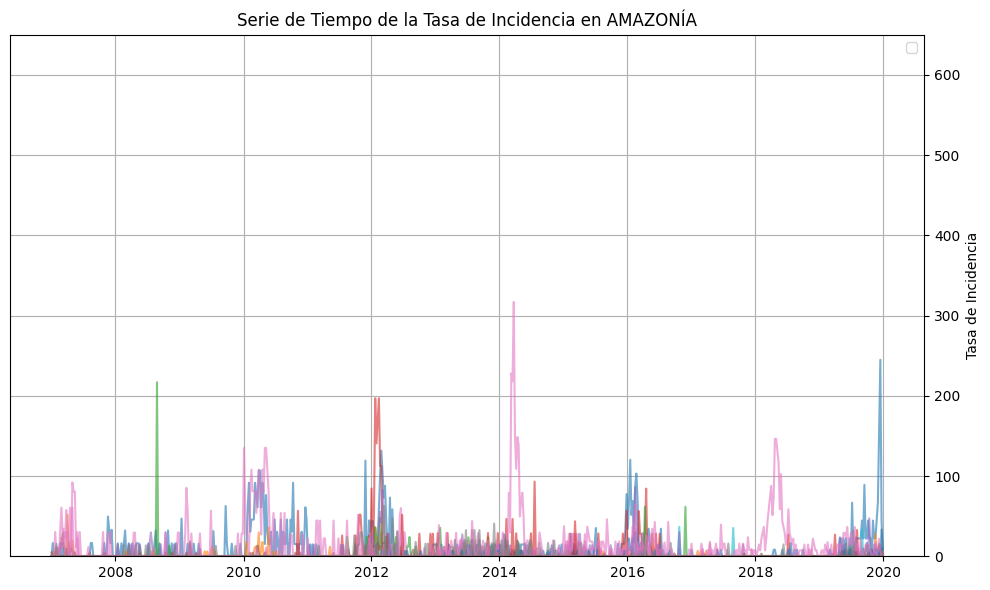

/tmp/ipython-input-18-920975910.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


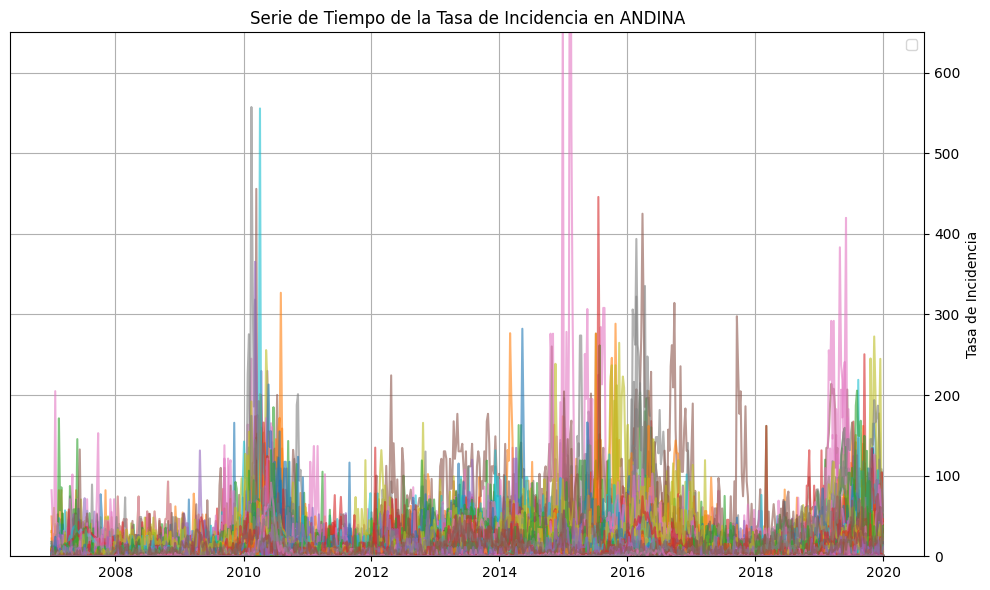

/tmp/ipython-input-18-920975910.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


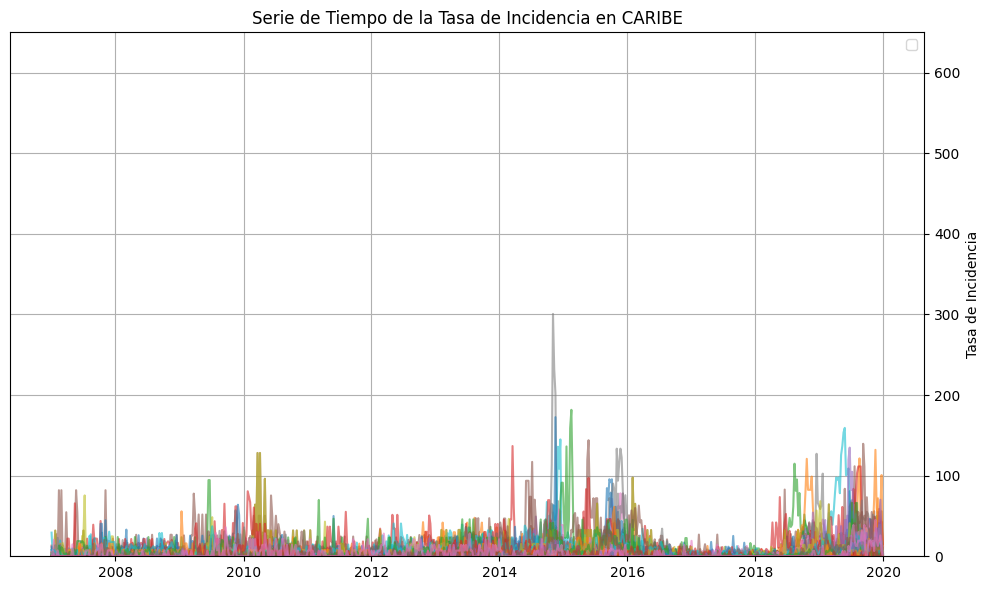

/tmp/ipython-input-18-920975910.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


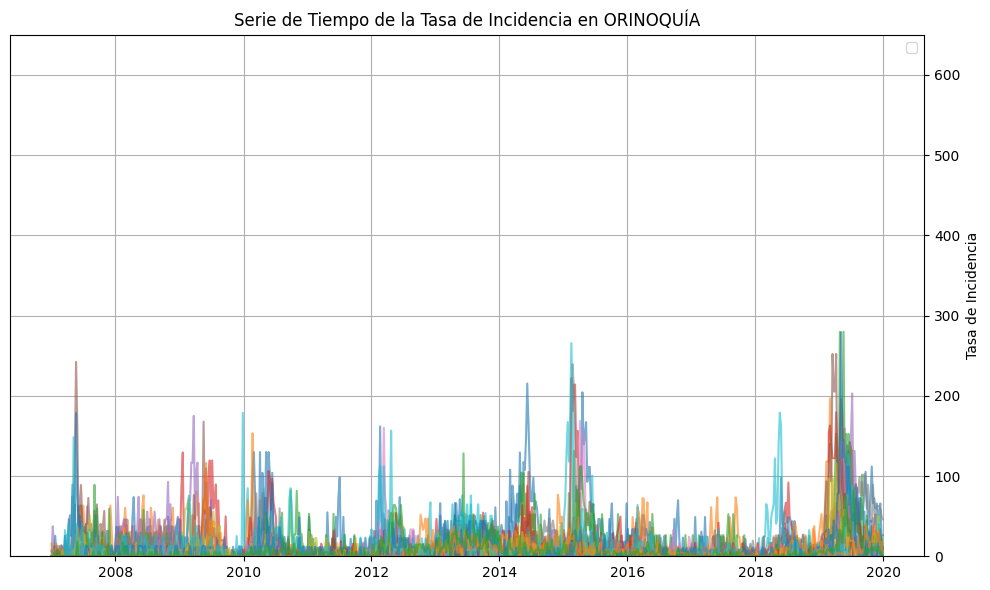

/tmp/ipython-input-18-920975910.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


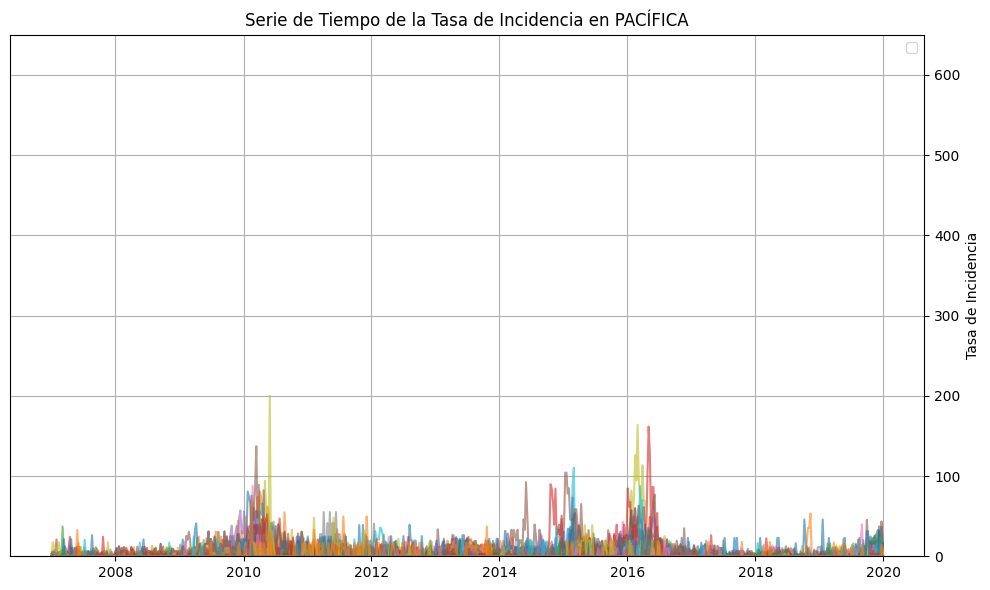

In [18]:
# Agrupar por región y obtener los municipios correspondientes
municipios_por_region = colombiac_with_region.groupby('REGION')['Municipio'].apply(list)

# Iterar por cada región
for region, municipios in municipios_por_region.items():
  # Crear una figura y un subplot para la serie de tiempo de la región
  fig, ax = plt.subplots(figsize=(10, 6))
  plt.title(f'Serie de Tiempo de la Tasa de Incidencia en {region}')

  # Iterar por cada municipio de la región
  for municipio in municipios:
    # Obtener los datos de tasa de incidencia del municipio actual
    municipio_data = colombiac_with_region[colombiac_with_region['Municipio'] == municipio]
    tasa_municipio = municipio_data[tasa_va.columns].iloc[0]

    # Convertir las semanas epidemiológicas a fechas para mejor visualización
    tasa_municipio.index = pd.to_datetime(tasa_municipio.index.str.extract(r't\.X(\d{4})\.w(\d{2})')[0] + tasa_municipio.index.str.extract(r't\.X(\d{4})\.w(\d{2})')[1].str.zfill(2) + '1', format='%Y%W%w')

    # Graficar la serie de tiempo del municipio actual
    ax.plot(tasa_municipio.index, tasa_municipio.values, alpha=0.6) # label=municipio

  # Configurar la leyenda y etiquetas del eje y
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.set_ylabel('Tasa de Incidencia')
  ax.legend()
  ax.grid(True)

  # Mostrar el gráfico
  plt.ylim(0, 650)
  plt.tight_layout()
  plt.show()

In [19]:
region_selected = 'ANDINA'

# Filtrar el DataFrame para obtener los puntos de la región seleccionada
region_points = colombiac_with_region[colombiac_with_region['REGION'] == region_selected]
region_points

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
104         SAN FRANCISCO  4.073567e+08  1.136071 -76.847267         86   
228             MANIZALES  4.410017e+08  5.083433 -75.507279         17   
229               AGUADAS  4.757327e+08  5.596775 -75.450358         17   
230                 NEIRA  3.693428e+08  5.183359 -75.506930         17   
231             MARULANDA  3.769595e+08  5.235585 -75.283166         17   
...                   ...           ...       ...        ...        ...   
1116           FUSAGASUGÁ  1.939529e+08  4.323534 -74.388591         25   
1117  SAN JUAN DE RIOSECO  3.140873e+08  4.841098 -74.658493         25   
1118                HONDA  3.048869e+08  5.179417 -74.783031         73   
1119             SABANETA  1.583532e+07  6.138305 -75.608806          5   
1120          LA ESTRELLA  3.663179e+07  6.137596 -75.648955          5   

      MPIO_ccdgo  MPIO_Code  \
104          755      86755   
228            1      17001   
229           13      17013   
230          486      17486   
231          446      17446   
...          ...        ...   
1116         290      25290   
1117         662      25662   
1118         349      73349   
1119         631       5631   
1120         380       5380   

                                               geometry            Municipio  \
104   POLYGON ((-76.87345 1.28986, -76.87219 1.28969...        San Francisco   
228   POLYGON ((-75.33722 5.04441, -75.33544 5.04402...            Manizales   
229   POLYGON ((-75.59452 5.73644, -75.59418 5.73635...              Aguadas   
230   POLYGON ((-75.66228 5.27432, -75.66203 5.27413...                Neira   
231   POLYGON ((-75.23991 5.3772, -75.23974 5.37719,...            Marulanda   
...                                                 ...                  ...   
1116  POLYGON ((-74.297 4.42407, -74.29696 4.42384, ...           Fusagasugá   
1117  POLYGON ((-74.72826 4.96905, -74.72815 4.96899...  San Juan de Rioseco   
1118  POLYGON ((-74.82173 5.31671, -74.82156 5.31653...                Honda   
1119  POLYGON ((-75.60355 6.1551, -75.6035 6.15506, ...             Sabaneta   
1120  POLYGON ((-75.65229 6.17061, -75.65216 6.1706,...          La Estrella   

      Municipio_code  ...  t.X2019.w48  t.X2019.w49  t.X2019.w50  t.X2019.w51  \
104            86755  ...     0.000000     0.000000     0.000000     0.000000   
228            17001  ...     0.907836     0.453918     0.000000     0.453918   
229            17013  ...     0.000000     0.000000     0.000000     0.000000   
230            17486  ...     4.752852     0.000000     0.000000     0.000000   
231            17446  ...     0.000000     0.000000     0.000000     0.000000   
...              ...  ...          ...          ...          ...          ...   
1116           25290  ...     0.682333     1.364666     2.046999     3.411665   
1117           25662  ...    24.026910     0.000000     0.000000     0.000000   
1118           73349  ...    77.282896    44.742729    61.012813    28.472646   
1119            5631  ...     0.000000     0.000000     1.169810     0.000000   
1120            5380  ...     0.000000     0.000000     1.356926     1.356926   

      t.X2019.w52                   centroid   longitud   latitud  \
104      0.000000  POINT (-76.84727 1.13607) -76.847267  1.136071   
228      0.000000  POINT (-75.50728 5.08343) -75.507279  5.083433   
229      0.000000  POINT (-75.45036 5.59678) -75.450358  5.596775   
230      0.000000  POINT (-75.50693 5.18336) -75.506930  5.183359   
231      0.000000  POINT (-75.28317 5.23559) -75.283166  5.235585   
...           ...                        ...        ...       ...   
1116     1.364666  POINT (-74.38859 4.32353) -74.388591  4.323534   
1117     0.000000   POINT (-74.65849 4.8411) -74.658493  4.841098   
1118    16.270083  POINT (-74.78303 5.17942) -74.783031  5.179417   
1119     0.000000  POINT (-75.60881 6.13831) -75.608806  6.138305   
1120     1.356926   POINT (-75.64895 6.1376) -75

In [20]:
#bins1 = [0, 1, 20, 40, 60, 80, 100, float('inf')]
bins1 = [0, 1, 10, 20, float('inf')]

### Arreglar el geometry del municipio Barranco Minas

In [21]:
C= gpd.read_file("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/Shape")

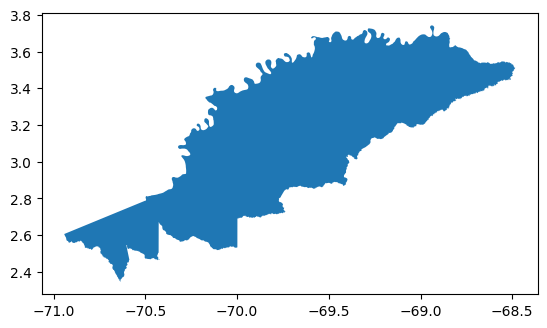

In [22]:
C[C['Cod_Mun'] == 94343].plot()
plt.show()

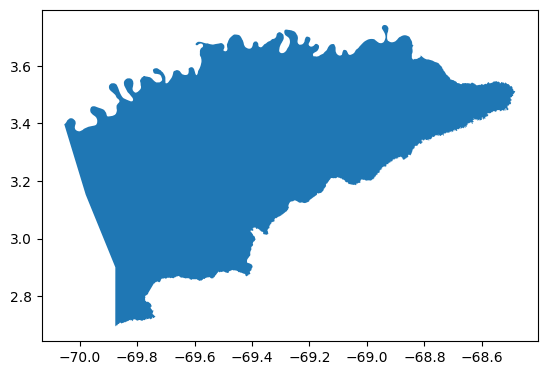

In [23]:
colombiac[colombiac['MPIO_Code'] == 94343].plot()
plt.show()

In [24]:
print("Tipo de MPIO_Code en colombiac:", colombiac['MPIO_Code'].dtype)
print("Tipo de Cod_Mun en C:", C['Cod_Mun'].dtype)


Tipo de MPIO_Code en colombiac: int64
Tipo de Cod_Mun en C: int32


In [25]:
colombiac['MPIO_Code'] = colombiac['MPIO_Code'].astype(int)
C['Cod_Mun'] = C['Cod_Mun'].astype(int)

In [26]:
nuevo_geometry = C.loc[C['Cod_Mun'] == 94343, 'geometry'].iloc[0]
colombiac.loc[colombiac['MPIO_Code'] == 94343, 'geometry'] = nuevo_geometry

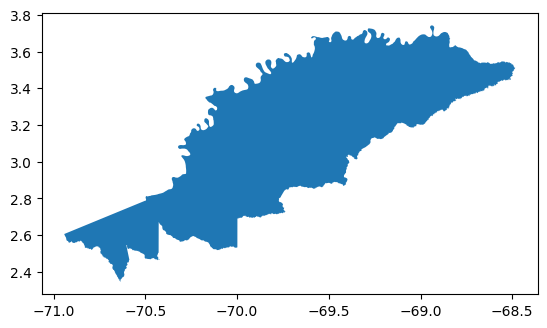

In [27]:
colombiac[colombiac['MPIO_Code'] == 94343].plot()
plt.show()

# Mapas

## zona andina

#### ...

In [ ]:
municipality_codes_in_region = region_points['MPIO_Code'].unique()
df_filtered = df[df['Municipality code'].isin(municipality_codes_in_region)].copy()
df_andina = pd.merge(df_filtered, region_points[['MPIO_Code', 'geometry', 'centroid',	'longitud',	'latitud'	]], left_on='Municipality code', right_on='Cod_Mun', how='left')


# Convertir GeoDataFrame
df_andina = gpd.GeoDataFrame(df_andina, geometry='geometry')
df_andina.head()

NameError: name 'df' is not defined

In [ ]:
#dimensiones
print(df_andina.shape)

In [ ]:
import matplotlib.pyplot as plt

vector_data = region_points.iloc[:, 11:687].values.flatten()

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(vector_data)
plt.title(f'Box Plot of Data for Region {region_selected}')
plt.ylabel('Data Values')
plt.show()

## Mapas tasas de incidencia

#### ...

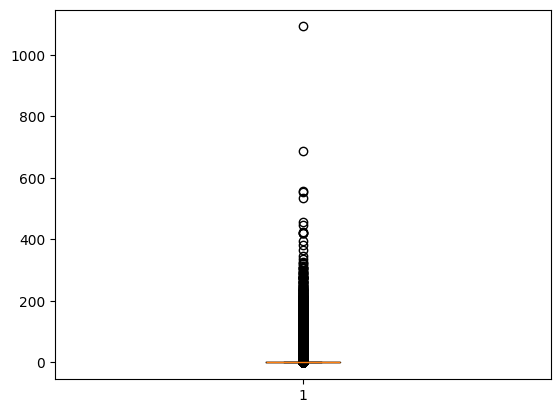

In [ ]:
vector = region_points.iloc[:, 11:-5]

# Select only the numeric columns from the DataFrame
numeric_vector = vector.select_dtypes(include=np.number)

# Convert the numeric DataFrame to a NumPy array before using flatten
tasa_values = numeric_vector.values.flatten()

plt.boxplot(tasa_values)
plt.show()

In [ ]:
import numpy as np

non_zero_values = tasa_values[tasa_values != 0]

q1 = np.quantile(non_zero_values, 0.25)
q2 = np.quantile(non_zero_values, 0.50)
q3 = np.quantile(non_zero_values, 0.75)

print(f"1st Quartile (Q1): {q1}")
print(f"2nd Quartile (Median, Q2): {q2}")
print(f"3rd Quartile (Q3): {q3}")

1st Quartile (Q1): 4.886630179827991
2nd Quartile (Median, Q2): 9.863878477017163
3rd Quartile (Q3): 19.131245247847737


In [ ]:
bins1 = [0, 1, 10, 20, float('inf')]

# Categorización
categories1 = pd.cut(tasa_values, bins=bins1, right = False)

# Contar las categorizaciones
categories1.value_counts()

[0.0, 1.0)      323696
[1.0, 10.0)      32389
[10.0, 20.0)     17789
[20.0, inf)      16276
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


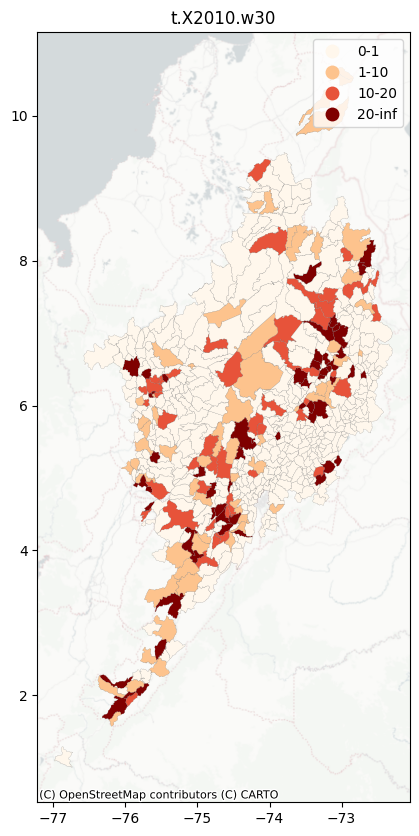

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
semana = 't.X2010.w30'

region_points['semana_cat'] = pd.cut(region_points[semana], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
region_points.plot(column='semana_cat', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.4', legend=True)
ctx.add_basemap(ax, crs=region_points.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

ax.set_title(f"{semana}")
plt.show()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


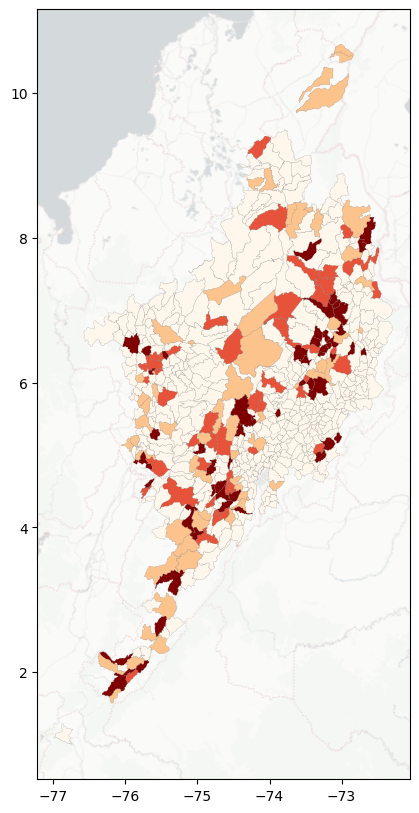

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
semana = 't.X2010.w30'

region_points['semana_cat'] = pd.cut(region_points[semana], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
region_points.plot(column='semana_cat', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

#ax.set_title(f"{semana}")
plt.show()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


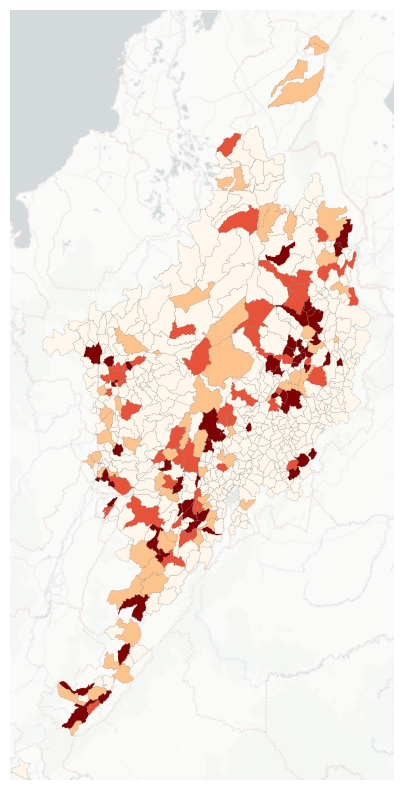

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 10))
semana = 't.X2010.w30'

region_points['semana_cat'] = pd.cut(region_points[semana], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
region_points.plot(column='semana_cat', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

# Establecer los límites del eje x e y
ax.set_xlim([-77, -72])
ax.set_ylim([1, 11])

# Ocultar los límites del mapa
ax.axis('off')


#ax.set_title(f"{semana}")
plt.show()


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


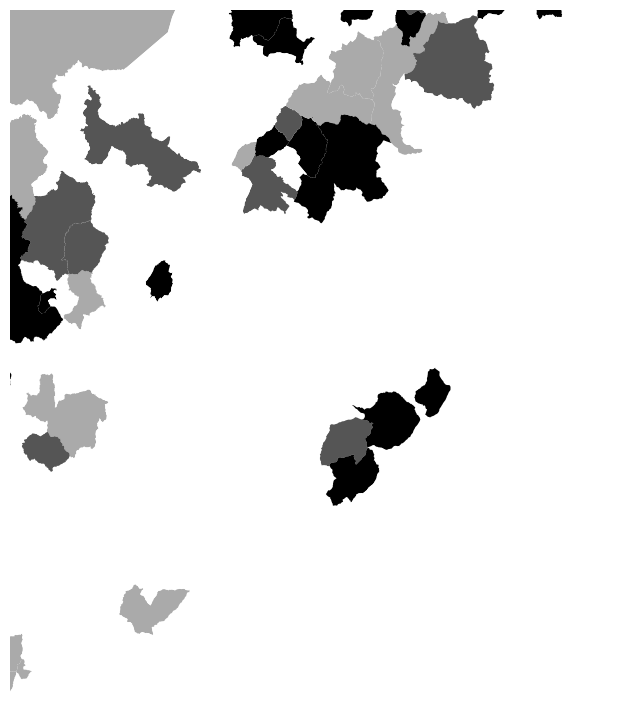

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,8.979))
semana = 't.X2010.w30'

region_points['semana_cat'] = pd.cut(region_points[semana], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
region_points.plot(column='semana_cat', cmap='gist_yarg', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
#ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)
#binary', 'gist_yarg', Greys
# Establecer los límites del eje x e y
ax.set_xlim([-74.34, -72.45])
ax.set_ylim([4.3, 6.4])


# Ocultar los límites del mapa
ax.axis('off')


#ax.set_title(f"{semana}")
plt.show()


### Colombia / departamentos

In [ ]:
bins1 = [0, 4, 8, 16, float('inf')]

In [ ]:
import matplotlib.cm as cm
cmap_original = cm.get_cmap("nipy_spectral")
from matplotlib.colors import LinearSegmentedColormap
cmap_recortado = LinearSegmentedColormap.from_list(
    "hsv_recortado", cmap_original(np.linspace(0.25, 0.95, 256))
)

#hsv 0 0.5

/tmp/ipython-input-29-2958429350.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_original = cm.get_cmap("nipy_spectral")


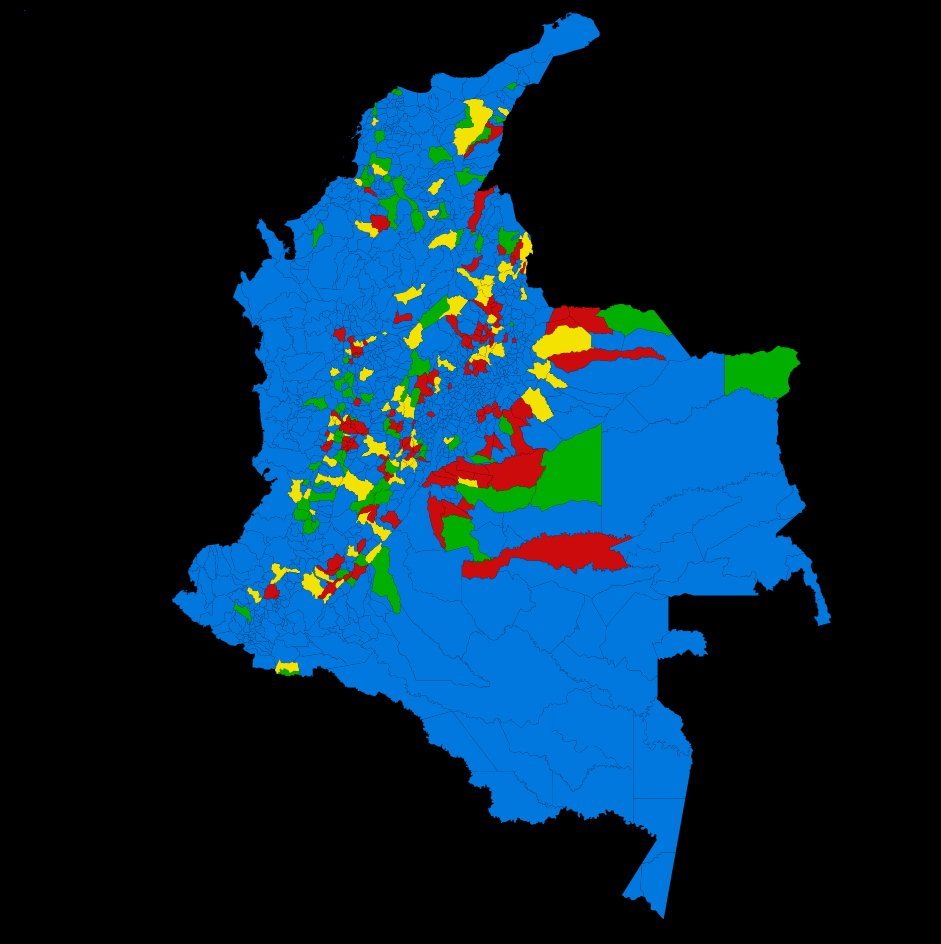

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')
semana = 't.X2010.w30'

colombiac['semana_cat'] = pd.cut(colombiac[semana], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
colombiac.plot(column='semana_cat', cmap= cmap_recortado, linewidth=0.01, ax=ax, edgecolor='0', legend=False) #cmap='OrRd', 'plasma' 'jet' 'rainbow' 'RdYlBu_r''gist_ncar'
#ctx.add_basemap(ax, crs=colombiac.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

# Establecer los límites del eje x e y
ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

# Ocultar los límites del mapa
ax.axis('off')


#ax.set_title(f"{semana}")
plt.show()

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gr...

In [ ]:
colombiac

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
0                  FLORENCIA  2.547638e+09  1.749139 -75.558239         18   
1                    ALBANIA  4.141221e+08  1.227865 -75.882327         18   
2     BELÉN DE LOS ANDAQUÍES  1.191619e+09  1.500923 -75.875645         18   
3                EL DONCELLO  1.106076e+09  1.791386 -75.193944         18   
4                  EL PAUJÍL  1.234734e+09  1.617746 -75.234043         18   
...                      ...           ...       ...        ...        ...   
1116              FUSAGASUGÁ  1.939529e+08  4.323534 -74.388591         25   
1117     SAN JUAN DE RIOSECO  3.140873e+08  4.841098 -74.658493         25   
1118                   HONDA  3.048869e+08  5.179417 -74.783031         73   
1119                SABANETA  1.583532e+07  6.138305 -75.608806          5   
1120             LA ESTRELLA  3.663179e+07  6.137596 -75.648955          5   

      MPIO_ccdgo  MPIO_Code  \
0              1      18001   
1             29      18029   
2             94      18094   
3            247      18247   
4            256      18256   
...          ...        ...   
1116         290      25290   
1117         662      25662   
1118         349      73349   
1119         631       5631   
1120         380       5380   

                                               geometry  \
0     POLYGON ((-75.42074 2.19413, -75.42042 2.19412...   
1     POLYGON ((-75.89506 1.3657, -75.89506 1.3657, ...   
2     POLYGON ((-75.78705 1.74982, -75.78715 1.74956...   
3     POLYGON ((-75.36167 2.32143, -75.36142 2.32122...   
4     POLYGON ((-75.36638 2.20952, -75.35963 2.17388...   
...                                                 ...   
1116  POLYGON ((-74.297 4.42407, -74.29696 4.42384, ...   
1117  POLYGON ((-74.72826 4.96905, -74.72815 4.96899...   
1118  POLYGON ((-74.82173 5.31671, -74.82156 5.31653...   
1119  POLYGON ((-75.60355 6.1551, -75.6035 6.15506, ...   
1120  POLYGON ((-75.65229 6.17061, -75.65216 6.1706,...   

                   Municipio  Municipio_code  ...  t.X2019.w44  t.X2019.w45  \
0                  Florencia           18001  ...     3.513621     7.027242   
1                    Albania           18029  ...    44.533511    22.266756   
2     Belén de Los Andaquíes           18094  ...     0.000000     0.000000   
3                El Doncello           18247  ...     0.000000     0.000000   
4                  El Paujíl           18256  ...     0.000000     0.000000   
...                      ...             ...  ...          ...          ...   
1116              Fusagasugá           25290  ...     1.364666     3.411665   
1117     San Juan de Rioseco           25662  ...     0.000000     0.000000   
1118                   Honda           73349  ...    12.202563    16.270083   
1119                Sabaneta            5631  ...     0.000000     1.169810   
1120             La Estrella            5380  ...     0.000000     2.713851   

      t.X2019.w46  t.X2019.w47  t.X2019.w48  t.X2019.w49  t.X2019.w50  \
0        2.342414     7.027242     8.198449     9.369656    15.811295   
1       22.266756    44.533511    66.800267   155.867290   244.934313   
2        0.000000     9.007386     0.000000     9.007386     9.007386   
3        0.000000    20.772746    15.579560    15.579560     5.193187   
4       10.958304     5.479152    16.437455     0.000000    10.958304   
...           ...          ...          ...          ...          ...   
1116     2.729332     3.411665     0.682333     1.364666     2.046999   
1117    12.013455     0.000000    24.026910     0.000000     0.000000   
1118    24.405125    16.270083    77.282896    44.742729    61.012813   
1119     1.169810     1.169810     0.000000     0.000000     1.169810   
1120     0.000000     0.000000     0.000000     0.000000     1.356926   

      t.X2019.w51  t.X2019.w52  semana_cat  
0        7.027242     8.784053         0-4  
1       44.533511     0.000000         0-4  
2        9.007386     0.000000        

####  Departamentos

-76.5144136084999 -74.06615269349984 2.871080699999993 5.319341615000042


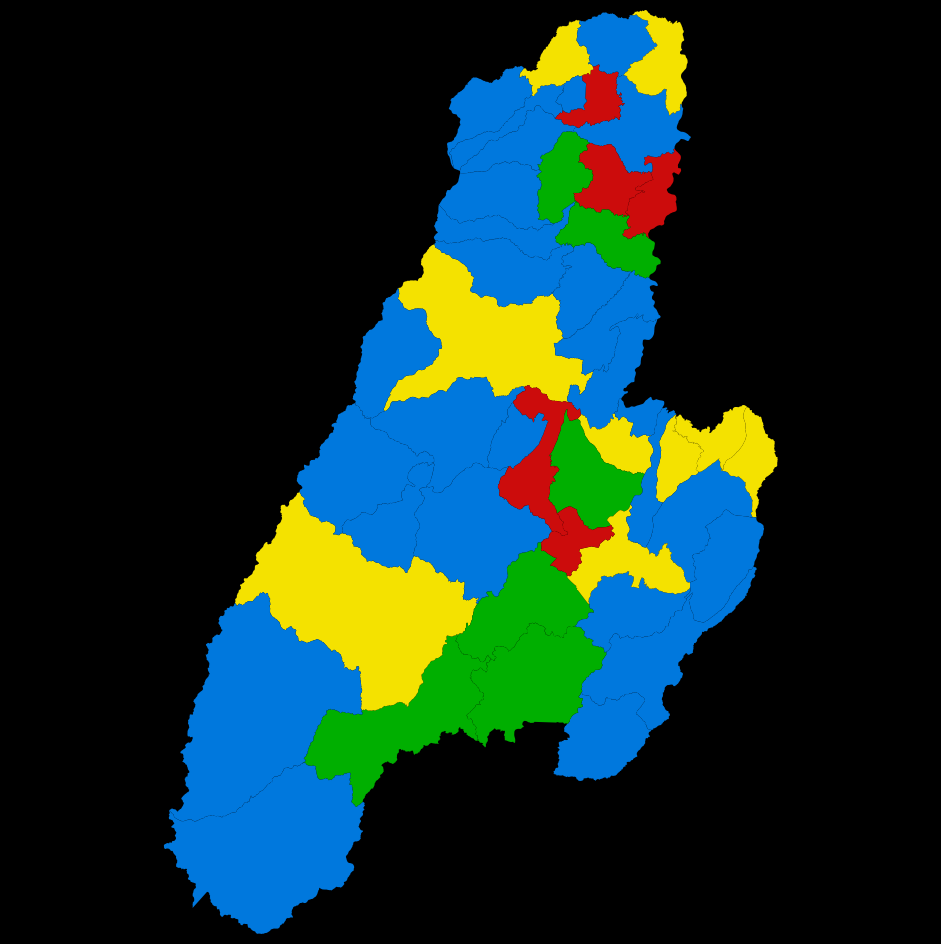

In [ ]:
colombia_norte = colombiac[colombiac['DPTO_Code'] == 73].copy()

# Semana y categoría
semana = 't.X2010.w30'
colombia_norte['semana_cat'] = pd.cut(
    colombia_norte[semana],
    bins=bins1,
    labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)],
    include_lowest=True
)

# Obtener límites
minx, miny, maxx, maxy = colombia_norte.total_bounds
width = maxx - minx
height = maxy - miny

# Igualar proporciones para cuadrado
if width > height:
    delta = (width - height) / 2
    miny -= delta
    maxy += delta
else:
    delta = (height - width) / 2
    minx -= delta
    maxx += delta

# Crear figura cuadrada
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

# Graficar
colombia_norte.plot(
    column='semana_cat',
    cmap=cmap_recortado,
    linewidth=0.01,
    ax=ax,
    edgecolor='0',
    legend=False
)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
print(minx, maxx, miny, maxy)

ax.axis('off')
plt.show()

In [ ]:
-76.5144136084999 -74.06615269349984 2.871080699999993 5.319341615000042

In [ ]:
-75.03--72.92

0.89

In [ ]:
print(-76.51--74.07)
print(2.87- 5.31)

-2.440000000000012
-2.45


### Imagenes colombia incidencia (articulo)

In [ ]:
import io
from PIL import Image
import re
import matplotlib.pyplot as plt
import pandas as pd
!pip install contextily
import contextily as ctx

def descargar_mapa_tasa_incidencia(inicio_semana, fin_semana, ruta_descarga):
    """
    Descarga mapas de tasa de incidencia para un rango de semanas epidemiológicas.

    Args:
        inicio_semana: Semana epidemiológica de inicio.
        fin_semana: Semana epidemiológica de fin.
        ruta_descarga: Ruta donde se guardarán los mapas.
    """
    # Filtrar los datos de la región seleccionada
    region_points = colombiac.copy()
    #bins1 = [0, 1, 10, 20, float('inf')]  # Categorías para la tasa de incidencia
    bins1 = [0, 0.01, 20, 40, float('inf')]
    # Renombrar las columnas que coincidan con el patrón t\.X\d+\.w\d+
    for col in region_points.columns:
        if re.match(r't\.X\d+\.w\d+', col):
            new_col = re.sub(r't\.X', '', col)
            region_points = region_points.rename(columns={col: new_col})

    # Verificar qué columnas contienen el patrón de semana después de renombrar
    columnas_semanas = region_points.columns[region_points.columns.str.contains(r'^\d+\.w\d+$')]


    cmap_original = cm.get_cmap("nipy_spectral")
    cmap_recortado = LinearSegmentedColormap.from_list(
        "hsv_recortado", cmap_original(np.linspace(0.25, 0.95, 256))
    )


    # Iterar sobre las semanas y generar los mapas
    for semana in columnas_semanas:
        if semana >= inicio_semana and semana <= fin_semana:
            # Crear la figura con fondo negro
            fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')  # Fondo negro

            # Crear categorías de la tasa de incidencia para la semana seleccionada
            region_points['semana_cat'] = pd.cut(
                region_points[semana],
                bins=bins1,
                labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)],
                include_lowest=True
            )

            # Graficar el mapa de la tasa de incidencia
            region_points.plot(
                column='semana_cat',
                cmap=cmap_recortado,
                linewidth=0,
                ax=ax,
                edgecolor='none',
                legend=False
            )

            # Añadir el mapa base con fondo transparente
            ctx.add_basemap(
                ax,
                crs=region_points.crs.to_string(),
                attribution=False,
                source=ctx.providers.CartoDB.PositronNoLabels,
                alpha=0
            )

            # Ajustar los límites del mapa
            ax.set_xlim([-82, -65])
            ax.set_ylim([-4.5, 12.5])
            ax.axis('off')

            # Guardar la figura en un buffer en memoria
            buf = io.BytesIO()
            plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=300, facecolor=fig.get_facecolor())
            buf.seek(0)

            # Crear una imagen PIL desde el buffer
            img = Image.open(buf)

            # Guardar la imagen en la ruta especificada
            nombre_archivo = f'{ruta_descarga}/{semana}.png'
            img.save(nombre_archivo)

            # Cerrar la figura para liberar memoria
            plt.close(fig)


In [ ]:
import os
ruta_descarga = '/content/drive/MyDrive/Incidencia'
#descargar_mapa_tasa_incidencia(region_selected='ANDINA', inicio_semana='2007.w01', fin_semana='2007.w52', ruta_descarga=ruta_descarga)
os.makedirs(ruta_descarga, exist_ok=True)
descargar_mapa_tasa_incidencia(inicio_semana='2011.w36', fin_semana='2019.w52', ruta_descarga=ruta_descarga)

<ipython-input-25-3704e35b142f>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_original = cm.get_cmap("nipy_spectral")


forma rasters


In [ ]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from PIL import Image
import re

def generar_rasters_clases_por_rango(region_points, inicio_semana, fin_semana, ruta_salida):
    bins = [0, 4, 8, 16, float('inf')]
    clases = [0, 1, 2, 3]

    # Renombrar columnas tipo t.X2021.w15 → 2021.w15
    for col in region_points.columns:
        if re.match(r't\.X\d+\.w\d+', col):
            nuevo = re.sub(r't\.X', '', col)
            region_points = region_points.rename(columns={col: nuevo})

    # Filtrar columnas que son semanas
    columnas_semanas = region_points.columns[region_points.columns.str.contains(r'^\d{4}\.w\d{2}$')]
    columnas_filtradas = sorted([col for col in columnas_semanas if inicio_semana <= col <= fin_semana])

    # Loop por semanas
    for semana in columnas_filtradas:
        print(f"Procesando {semana}...")

        try:
            region_points['semana_class'] = pd.cut(
                region_points[semana],
                bins=bins,
                labels=clases,
                include_lowest=True
            ).astype(np.uint8)

            out_shape = (1024, 1024)
            transform = from_bounds(-82, -4.5, -65, 12.5, *out_shape)

            shapes = [
                (geom, value)
                for geom, value in zip(region_points.geometry, region_points['semana_class'])
                if value in clases
            ]

            raster = rasterize(
                shapes=shapes,
                out_shape=out_shape,
                transform=transform,
                fill=255,
                dtype=np.uint8
            )

            nombre_archivo = f"{ruta_salida}/{semana}.png"
            Image.fromarray(raster).save(nombre_archivo)
            print(f"Guardado: {nombre_archivo}")

        except Exception as e:
            print(f"Error en semana {semana}: {e}")


In [ ]:
generar_rasters_clases_por_rango(
    region_points=colombiac,
    inicio_semana="2007.w01",
    fin_semana="2014.w52",
    ruta_salida="/content/drive/MyDrive/Incidencia"
)


Procesando 2007.w01...
Error en semana 2007.w01: [Errno 2] No such file or directory: '/content/drive/MyDrive/Incidencia/2007.w01.tif'
Procesando 2007.w02...
Error en semana 2007.w02: [Errno 2] No such file or directory: '/content/drive/MyDrive/Incidencia/2007.w02.tif'
Procesando 2007.w03...
Error en semana 2007.w03: [Errno 2] No such file or directory: '/content/drive/MyDrive/Incidencia/2007.w03.tif'
Procesando 2007.w04...
Guardado: /content/drive/MyDrive/Incidencia/2007.w04.tif
Procesando 2007.w05...


KeyboardInterrupt: 

.tif

In [ ]:
def generar_rasters_clases_por_rango(region_points, inicio_semana, fin_semana, ruta_salida):
    bins = [0, 4, 8, 16, float('inf')]
    clases = [0, 1, 2, 3]

    # Crear directorio si no existe
    os.makedirs(ruta_salida, exist_ok=True)

    # Renombrar columnas tipo t.X2021.w15 → 2021.w15
    for col in region_points.columns:
        if re.match(r't\.X\d+\.w\d+', col):
            nuevo = re.sub(r't\.X', '', col)
            region_points = region_points.rename(columns={col: nuevo})

    # Filtrar columnas semana dentro del rango
    columnas_semanas = region_points.columns[region_points.columns.str.contains(r'^\d{4}\.w\d{2}$')]
    columnas_filtradas = sorted([col for col in columnas_semanas if inicio_semana <= col <= fin_semana])

    # Loop por semanas
    for semana in columnas_filtradas:
        print(f"Procesando {semana}...")

        try:
            region_points['semana_class'] = pd.cut(
                region_points[semana],
                bins=bins,
                labels=clases,
                include_lowest=True
            ).astype(np.uint8)

            out_shape = (1024, 1024)
            transform = from_bounds(-82, -4.5, -65, 12.5, *out_shape)

            shapes = [
                (geom, value)
                for geom, value in zip(region_points.geometry, region_points['semana_class'])
                if value in clases
            ]

            raster = rasterize(
                shapes=shapes,
                out_shape=out_shape,
                transform=transform,
                fill=255,
                dtype=np.uint8
            )

            nombre_archivo = os.path.join(ruta_salida, f"{semana}.tif")

            with rasterio.open(
                nombre_archivo,
                "w",
                driver="GTiff",
                height=out_shape[0],
                width=out_shape[1],
                count=1,
                dtype=raster.dtype,
                crs="EPSG:4326",
                transform=transform
            ) as dst:
                dst.write(raster, 1)

            print(f"Guardado: {nombre_archivo}")

        except Exception as e:
            print(f"Error en semana {semana}: {e}")


In [ ]:
generar_rasters_clases_por_rango(
    region_points=colombiac,
    inicio_semana="2015.w01",
    fin_semana="2019.w52",
    ruta_salida="/content/drive/MyDrive/Incidencia"
)

Procesando 2015.w01...
Guardado: /content/drive/MyDrive/Incidencia/2015.w01.tif
Procesando 2015.w02...
Guardado: /content/drive/MyDrive/Incidencia/2015.w02.tif
Procesando 2015.w03...
Guardado: /content/drive/MyDrive/Incidencia/2015.w03.tif
Procesando 2015.w04...
Guardado: /content/drive/MyDrive/Incidencia/2015.w04.tif
Procesando 2015.w05...
Guardado: /content/drive/MyDrive/Incidencia/2015.w05.tif
Procesando 2015.w06...
Guardado: /content/drive/MyDrive/Incidencia/2015.w06.tif
Procesando 2015.w07...
Guardado: /content/drive/MyDrive/Incidencia/2015.w07.tif
Procesando 2015.w08...
Guardado: /content/drive/MyDrive/Incidencia/2015.w08.tif
Procesando 2015.w09...
Guardado: /content/drive/MyDrive/Incidencia/2015.w09.tif
Procesando 2015.w10...
Guardado: /content/drive/MyDrive/Incidencia/2015.w10.tif
Procesando 2015.w11...
Guardado: /content/drive/MyDrive/Incidencia/2015.w11.tif
Procesando 2015.w12...
Guardado: /content/drive/MyDrive/Incidencia/2015.w12.tif
Procesando 2015.w13...
Guardado: /conten

### Guardar imagenes

In [ ]:
import io
from PIL import Image
import re
import matplotlib.pyplot as plt
import pandas as pd
!pip install contextily
import contextily as ctx

def descargar_mapa_tasa_incidencia(region_selected, inicio_semana, fin_semana, ruta_descarga):
    """
    Descarga mapas de tasa de incidencia para un rango de semanas epidemiológicas.

    Args:
        region_selected: Región seleccionada para el mapa.
        inicio_semana: Semana epidemiológica de inicio.
        fin_semana: Semana epidemiológica de fin.
        ruta_descarga: Ruta donde se guardarán los mapas.
    """
    # Filtrar los datos de la región seleccionada
    region_points = colombiac.copy()
    #bins1 = [0, 1, 20, 40, 60, 80, 100, float('inf')]
    #bins1 = [0, 1, 25, 50, 75, 100, float('inf')]
    bins1 = [0, 1, 10, 20, float('inf')]
    # Renombrar las columnas que coincidan con el patrón t\.X\d+\.w\d+
    for col in region_points.columns:
        if re.match(r't\.X\d+\.w\d+', col):
            new_col = re.sub(r't\.X', '', col)
            region_points = region_points.rename(columns={col: new_col})

    # Verificar qué columnas contienen el patrón de semana después de renombrar
    columnas_semanas = region_points.columns[region_points.columns.str.contains(r'^\d+\.w\d+$')]

    # Iterar sobre las semanas y generar los mapas
    for semana in columnas_semanas:
        if semana >= inicio_semana and semana <= fin_semana:
            fig, ax = plt.subplots(1, 1, figsize=(12, 12))

            # Crear categorías de la tasa de incidencia para la semana seleccionada
            region_points['semana_cat'] = pd.cut(
                region_points[semana],
                bins=bins1,
                labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)],
                include_lowest=True
            )

            # Graficar el mapa de la tasa de incidencia
            region_points.plot(
                column='semana_cat',
                #cmap='gist_yarg',
                cmap='OrRd',
                #linewidth=0.1,
                linewidth=0,
                ax=ax,
                edgecolor='0.4',
                legend=False
            )

            # Añadir el mapa base con contextily
            ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

            # Ajustar los límites del mapa
            #ax.set_xlim([-77, -72])
            #ax.set_ylim([1, 11])
            ax.set_xlim([-76, -72])
            ax.set_ylim([3.5, 7.5])
            ax.axis('off')

            # Guardar la figura en un buffer en memoria
            buf = io.BytesIO()
            plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=300)
            buf.seek(0)

            # Crear una imagen PIL desde el buffer
            img = Image.open(buf)

            # Guardar la imagen en la ruta especificada
            nombre_archivo = f'{ruta_descarga}/{semana}.png'
            img.save(nombre_archivo)

            # Cerrar la figura para liberar memoria
            plt.close(fig)


In [ ]:
import os
ruta_descarga = '/content/drive/MyDrive/Incidencia'
#descargar_mapa_tasa_incidencia(region_selected='ANDINA', inicio_semana='2007.w01', fin_semana='2007.w52', ruta_descarga=ruta_descarga)
os.makedirs(ruta_descarga, exist_ok=True)
descargar_mapa_tasa_incidencia(region_selected='ANDINA', inicio_semana='2018.w50', fin_semana='2019.w01', ruta_descarga=ruta_descarga)

## NBI

In [ ]:
print(nbi.columns)

In [ ]:
nbi['Prop de Personas en NBI (%)'].plot(kind='hist', bins=40)

In [ ]:
#Obtener los centroides
nbi_ = nbi.copy()
# Apply centroid directly to the geometry column
nbi_['centroid'] = nbi_.geometry.apply(lambda x: x.centroid)

#Coordenadas de los centroides
# Access the x and y coordinates of each centroid using apply function
nbi_['longitud'] = nbi_.centroid.apply(lambda p: p.x)
nbi_['latitud'] = nbi_.centroid.apply(lambda p: p.y)

In [ ]:
import geopandas as gpd
if not isinstance(nbi_, gpd.GeoDataFrame):
  nbi_ = gpd.GeoDataFrame(nbi_, geometry=gpd.points_from_xy(nbi_.longitud, nbi_.latitud))
if nbi_.crs != regiones_shp.crs:
  nbi_ = nbi_.to_crs(regiones_shp.crs)
nbi_with_region = gpd.sjoin(nbi_, regiones_shp, how='left', predicate='within')
print(nbi_with_region.head())

In [ ]:
# Para la región Andina
region_selected = 'ANDINA'
#region_points = nbi_with_region[nbi_with_region['REGION'] == region_selected].copy()
region_points = nbi_with_region.copy()


In [ ]:
region_points['Prop de Personas en NBI (%)'].plot(kind='hist', bins=40)

In [ ]:
bins2 = [0, 20, 40, 60, 80, 100, float('inf')]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

region_points['binned_data'] = pd.cut(region_points['Prop de Personas en NBI (%)'], bins=bins2, labels=[f'{bins2[i]}-{bins2[i+1]}' for i in range(len(bins2)-1)], include_lowest=True)
#region_points.plot(column='binned_data', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.4', legend=True)
region_points.plot(column='binned_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

region_points['binned_data'] = pd.cut(region_points['Prop de Personas en NBI (%)'], bins=bins2, labels=[f'{bins2[i]}-{bins2[i+1]}' for i in range(len(bins2)-1)], include_lowest=True)
region_points.plot(column='binned_data', cmap='OrRd', linewidth=0.1, ax=ax, edgecolor='0.4', legend=False)
#ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

# Establecer los límites del eje x e y
#ax.set_xlim([-77, -72])
#ax.set_ylim([1, 11])

#ax.set_xlim([-78, -70])
#ax.set_ylim([1.5, 7])

ax.set_xlim([-76, -72])
ax.set_ylim([3.5, 7.5])

# Ocultar los límites del mapa
ax.axis('off')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

region_points['binned_data'] = pd.cut(region_points['Prop de Personas en NBI (%)'], bins=bins2, labels=[f'{bins2[i]}-{bins2[i+1]}' for i in range(len(bins2)-1)], include_lowest=True)
region_points.plot(column='binned_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
#ctx.add_basemap(ax, crs=region_points.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels)

# Establecer los límites del eje x e y
#ax.set_xlim([-77, -72])
#ax.set_ylim([1, 11])

#ax.set_xlim([-78, -70])
#ax.set_ylim([1.5, 7])

ax.set_xlim([-76, -72])
ax.set_ylim([3.5, 7.5])

# Ocultar los límites del mapa
ax.axis('off')

plt.show()

# Imagenes sociales para articulo


[DANE-Datos](https://geoportal.dane.gov.co/geovisores/sociedad/indicadores-regionales/)

## Datos

In [28]:
nbi=pd.read_excel("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/NBI.xlsx")
pobreza = pd.read_excel("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/pobreza.xlsx")
vivienda = pd.read_excel("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/vivienda.xlsx")
edad_sexo = pd.read_excel("/content/drive/Shareddrives/JAVIERA_DENGUE/CODE/BBDD/DCD-area-sexo-edad-proypoblacion-Mun-2005-2019.xlsx")

In [29]:
vivienda = colombia.merge(vivienda, left_on="MPIO_Code", right_on="cod_municipio")
pobreza = colombia.merge(pobreza, left_on="MPIO_Code", right_on="cod_municipio")
nbi = colombia.merge(nbi, left_on="MPIO_Code", right_on="cod_municipio")
edad_sexo = colombia.merge(edad_sexo, left_on="MPIO_Code", right_on="MPIO")

## Antes

## Indice de pobreza


### Privación por acceso a fuente de agua mejorada

In [ ]:
max(pobreza['si_ac_fu_ag'])

99.0

In [ ]:
bins1 = [0, 10, 14.1, 18.3, 44.4, 100, float('inf')]

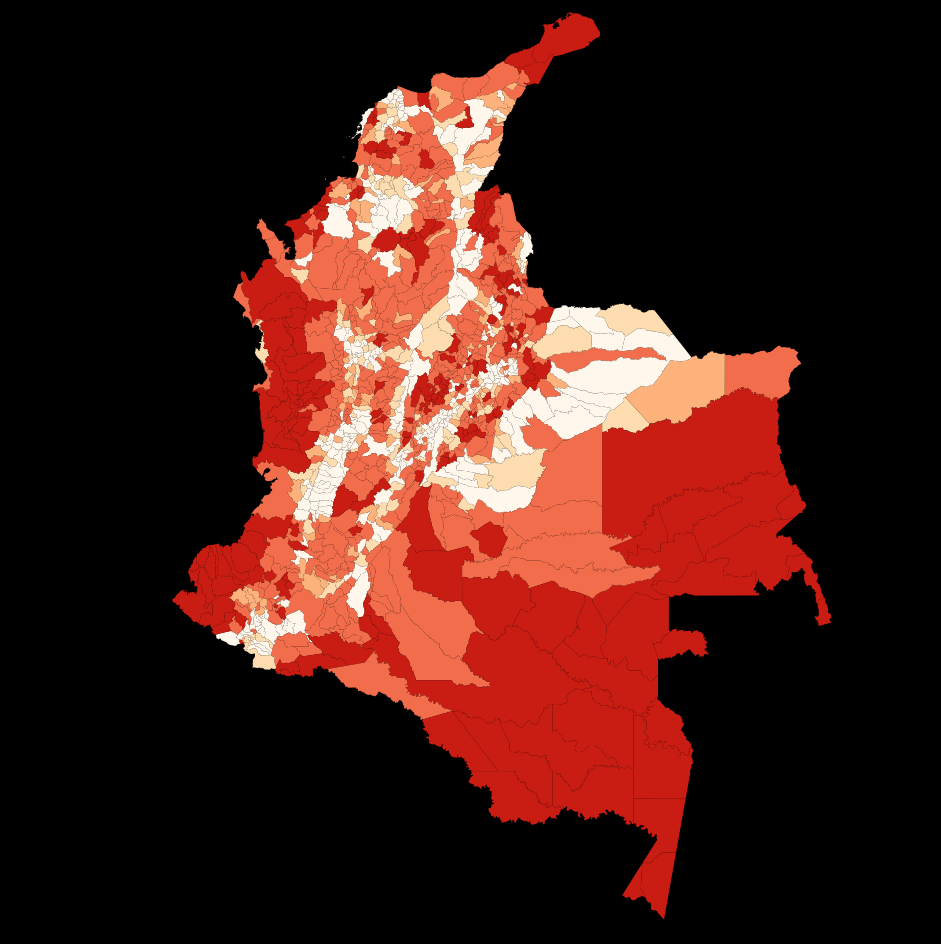

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

pobreza['bin_data'] = pd.cut(pobreza['si_ac_fu_ag'], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
pobreza.plot(column='bin_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=pobreza.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.show()

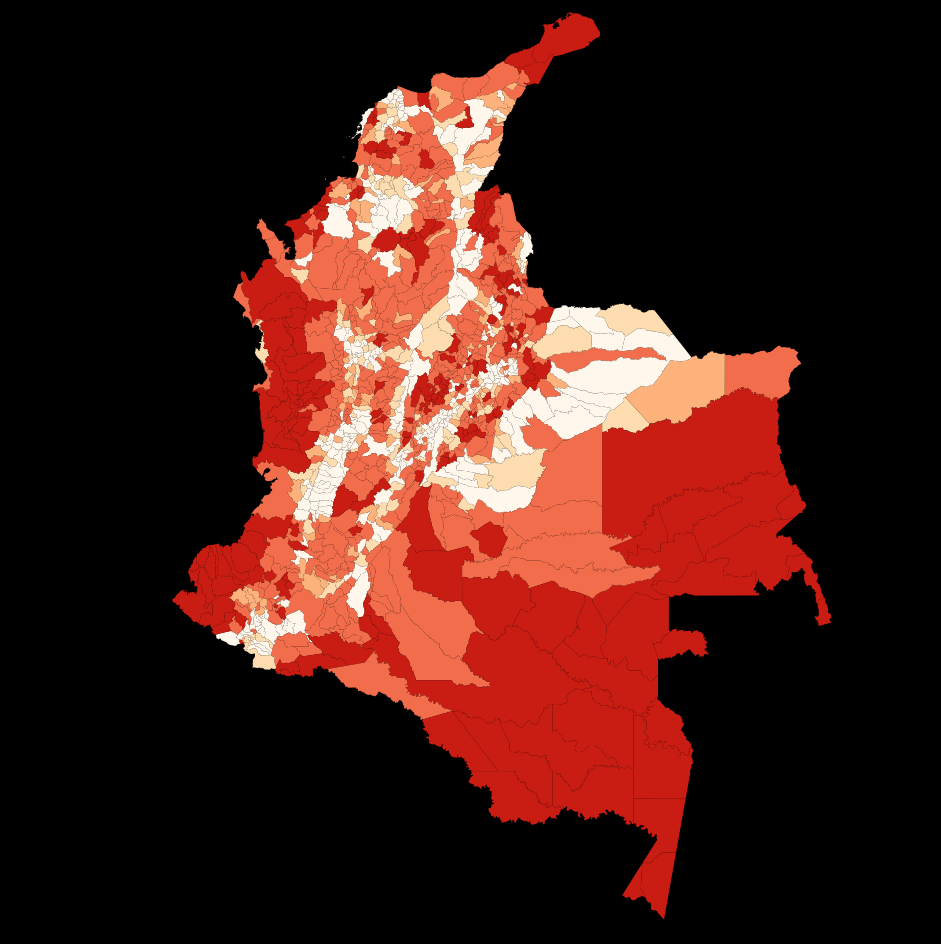

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

pobreza['bin_data'] = pd.cut(pobreza['si_ac_fu_ag'], bins=bins1, labels=[f'{bins1[i]}-{bins1[i+1]}' for i in range(len(bins1)-1)], include_lowest=True)
pobreza.plot(column='bin_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=pobreza.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('pobreza_acceso_agua.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('pobreza_acceso_agua.png')

generar .tif

## NBI

### Completo

In [ ]:
bins = [0, 25, 50, 75, float('inf')]

In [ ]:
if 'anio' in nbi.columns:
  nbi_2005 = nbi[nbi['anio'] == 2005]
  nbi_2018 = nbi[nbi['anio'] == 2018]

In [ ]:
nbi_2005

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  \
0                  FLORENCIA  2.547638e+09  1.749139 -75.558239         18   
2                    ALBANIA  4.141221e+08  1.227865 -75.882327         18   
4     BELÉN DE LOS ANDAQUÍES  1.191619e+09  1.500923 -75.875645         18   
6                EL DONCELLO  1.106076e+09  1.791386 -75.193944         18   
8                  EL PAUJÍL  1.234734e+09  1.617746 -75.234043         18   
...                      ...           ...       ...        ...        ...   
2230              FUSAGASUGÁ  1.939529e+08  4.323534 -74.388591         25   
2232     SAN JUAN DE RIOSECO  3.140873e+08  4.841098 -74.658493         25   
2234                   HONDA  3.048869e+08  5.179417 -74.783031         73   
2236                SABANETA  1.583532e+07  6.138305 -75.608806          5   
2238             LA ESTRELLA  3.663179e+07  6.137596 -75.648955          5   

      MPIO_ccdgo  MPIO_Code  \
0              1      18001   
2             29      18029   
4             94      18094   
6            247      18247   
8            256      18256   
...          ...        ...   
2230         290      25290   
2232         662      25662   
2234         349      73349   
2236         631       5631   
2238         380       5380   

                                               geometry  cod_departamento  \
0     POLYGON ((-75.42074 2.19413, -75.42042 2.19412...                18   
2     POLYGON ((-75.89506 1.3657, -75.89506 1.3657, ...                18   
4     POLYGON ((-75.78705 1.74982, -75.78715 1.74956...                18   
6     POLYGON ((-75.36167 2.32143, -75.36142 2.32122...                18   
8     POLYGON ((-75.36638 2.20952, -75.35963 2.17388...                18   
...                                                 ...               ...   
2230  POLYGON ((-74.297 4.42407, -74.29696 4.42384, ...                25   
2232  POLYGON ((-74.72826 4.96905, -74.72815 4.96899...                25   
2234  POLYGON ((-74.82173 5.31671, -74.82156 5.31653...                73   
2236  POLYGON ((-75.60355 6.1551, -75.6035 6.15506, ...                 5   
2238  POLYGON ((-75.65229 6.17061, -75.65216 6.1706,...                 5   

      departamento  hacinamiento  servicios  vivienda  personas_nbi  \
0          CAQUETA         13.40       2.08      7.30         26.85   
2          CAQUETA          9.66       5.54     11.45         35.03   
4          CAQUETA         12.15      17.58     11.48         47.83   
6          CAQUETA         12.98       7.76     15.25         42.34   
8          CAQUETA         18.78      18.29     27.30         54.22   
...            ...           ...        ...       ...           ...   
2230  CUNDINAMARCA          8.96       0.82      0.94         17.44   
2232  CUNDINAMARCA          7.31       6.87     16.93         34.15   
2234        TOLIMA          7.90       1.74      2.61         18.83   
2236     ANTIOQUIA          2.49       0.58      0.01          6.84   
2238     ANTIOQUIA          5.26       0.89      0.27         11.64   

      inasistencia  miseria  anio  cod_municipio               municipio  \
0             3.49     8.01  2005          18001               FLORENCIA   
2             4.69    10.26  2005          18029                 ALBANIA   
4             4.07    16.99  2005          18094  BELEN DE LOS ANDAQUIES   
6             4.14    14.53  2005          18247             EL DONCELLO   
8             4.52    24.59  2005          18256               EL PAUJIL   
...            ...      ...   ...            ...                     ...   
2230          4.24     3.99  2005          25290              FUSAGASUGA   
2232          1.23    10.06  2005          25662     SAN JUAN DE RIOSECO   
2234          3.29     4.89  2005          73349                   HONDA   
2236          0.12     0.70  2005           5631                SABANETA   
2238          1.21     1.38  2005           5380             LA ESTRELLA   

      clase  
0  

### Componente servicios

#### visualizacion

In [ ]:
bins2 = [0, 3.91, 7.55, 12.19, 22.36, 100, float('inf')]

In [ ]:
print(min(nbi_2005['servicios']))
print(max(nbi_2005['servicios']))
print(min(nbi_2018['servicios']))
print(max(nbi_2018['servicios']))

0.01
100.0
0.0
91.85


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


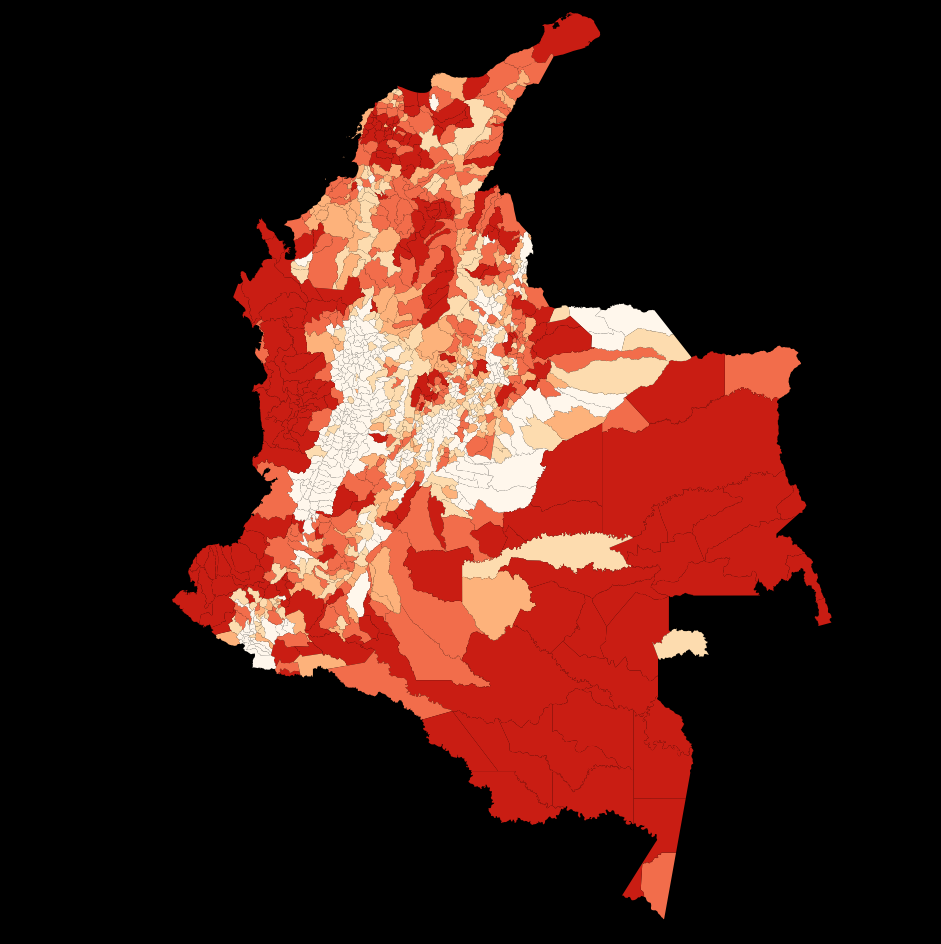

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

nbi_2005['bin_data'] = pd.cut(nbi_2005['servicios'], bins=bins2, labels=[f'{bins2[i]}-{bins2[i+1]}' for i in range(len(bins2)-1)], include_lowest=True)
nbi_2005.plot(column='bin_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=nbi_2005.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('nbi_serv_2005.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('nbi_serv_2005.png')

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


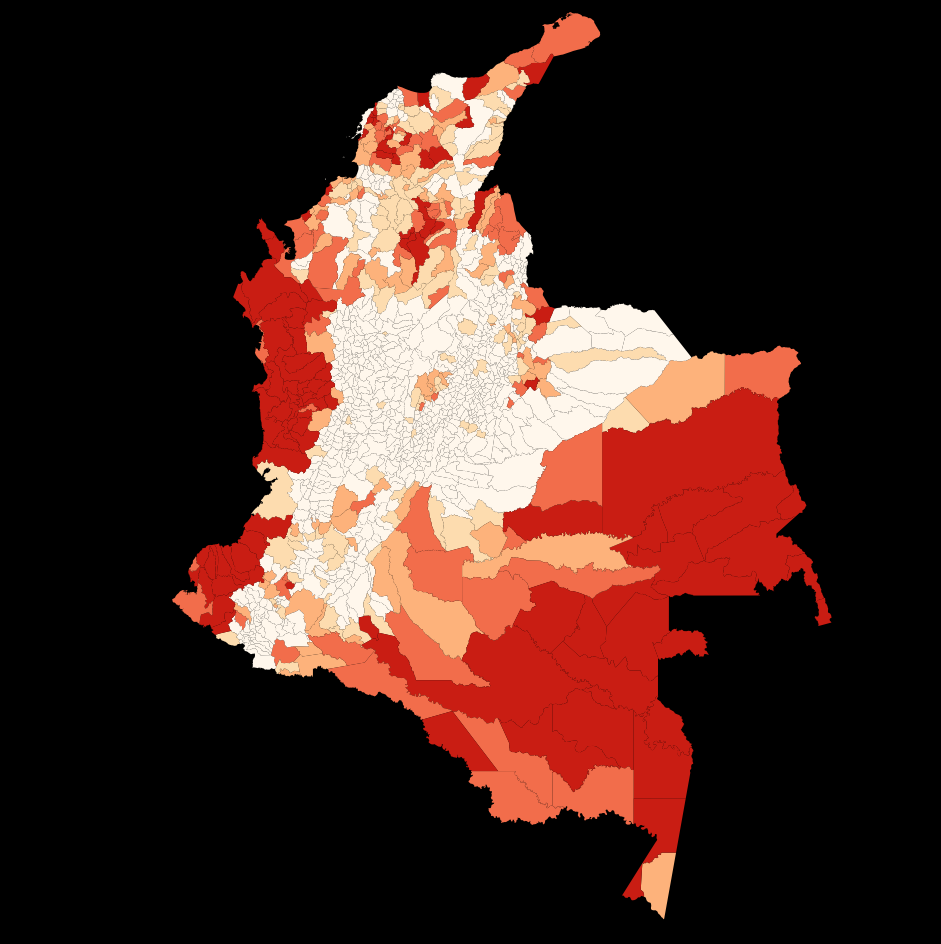

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

nbi_2018['bin_data'] = pd.cut(nbi_2018['servicios'], bins=bins2, labels=[f'{bins2[i]}-{bins2[i+1]}' for i in range(len(bins2)-1)], include_lowest=True)
nbi_2018.plot(column='bin_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=nbi_2018.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('nbi_serv_2018.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('nbi_serv_2018.png')

#### Generar raster

In [ ]:
def generar_raster_nbi(gdf, columna_valor, bins, output_path, out_shape=(1024, 1024)):
    # Crear clases a partir de los bins
    clases = list(range(len(bins) - 1))
    gdf['clase'] = pd.cut(
        gdf[columna_valor],
        bins=bins,
        labels=clases,
        include_lowest=True
    ).astype(np.uint8)

    # Transformación espacial
    transform = from_bounds(-82, -4.5, -65, 12.5, *out_shape)

    # Preparar shapes
    shapes = [
        (geom, int(value))
        for geom, value in zip(gdf.geometry, gdf['clase'])
        if not pd.isna(value)
    ]

    # Rasterizar
    raster = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=255,  # fondo = 255
        dtype=np.uint8
    )

    # Guardar como PNG
    Image.fromarray(raster).save(output_path)
    print(f" Imagen guardada: {output_path}")


In [ ]:
bins2 = [0, 3.91, 7.55, 12.19, 22.36, 100, float('inf')]

nbi_2005 = nbi[nbi['anio'] == 2005].copy()
nbi_2018 = nbi[nbi['anio'] == 2018].copy()

# Generar imágenes de clases
generar_raster_nbi(nbi_2005, columna_valor='servicios', bins=bins2, output_path='nbi_serv_2005_labels.png')
generar_raster_nbi(nbi_2018, columna_valor='servicios', bins=bins2, output_path='nbi_serv_2018_labels.png')

 Imagen guardada: nbi_serv_2005_labels.png
 Imagen guardada: nbi_serv_2018_labels.png


guardar como .tif

In [ ]:
def generar_raster_nbi_tif(gdf, columna_valor, bins, output_path, out_shape=(1024, 1024)):
    # Crear clases
    clases = list(range(len(bins) - 1))
    gdf['clase'] = pd.cut(
        gdf[columna_valor],
        bins=bins,
        labels=clases,
        include_lowest=True
    ).astype(np.uint8)

    # Transformación espacial
    transform = from_bounds(-82, -4.5, -65, 12.5, *out_shape)

    # Rasterizar
    shapes = [
        (geom, int(value))
        for geom, value in zip(gdf.geometry, gdf['clase'])
        if not pd.isna(value)
    ]
    raster = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=255,
        dtype=np.uint8
    )

    # Guardar como TIFF
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",
        transform=transform
    ) as dst:
        dst.write(raster, 1)

    print(f" GeoTIFF guardado: {output_path}")

In [ ]:
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
bins2 = [0, 3.91, 7.55, 12.19, 22.36, 100, float('inf')]

nbi_2005 = nbi[nbi['anio'] == 2005].copy()
nbi_2018 = nbi[nbi['anio'] == 2018].copy()

# Generar imágenes de clases
generar_raster_nbi_tif(nbi_2005, columna_valor='miseria', bins=bins2, output_path='/content/drive/MyDrive/Imagen_unet/nbi_mise_2005_labels.tif')
generar_raster_nbi_tif(nbi_2018, columna_valor='miseria', bins=bins2, output_path='/content/drive/MyDrive/Imagen_unet/nbi_mise_2018_labels.tif')

 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/nbi_mise_2005_labels.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/nbi_mise_2018_labels.tif


### propoción de personas en miseria

In [ ]:
print(min(nbi_2005['miseria']))
print(max(nbi_2005['miseria']))
print(min(nbi_2018['miseria']))
print(max(nbi_2018['miseria']))

0.23
100.0
0.0
82.02


In [ ]:
nbi['miseria'].quantile([0, 0.25, 0.5, 0.75, 1])

0.00      0.0000
0.25      2.3575
0.50      7.5200
0.75     18.5625
1.00    100.0000
Name: miseria, dtype: float64

In [ ]:
bins3 = [0, 6.65, 10.48, 15, 26.85, 100, float('inf')]

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


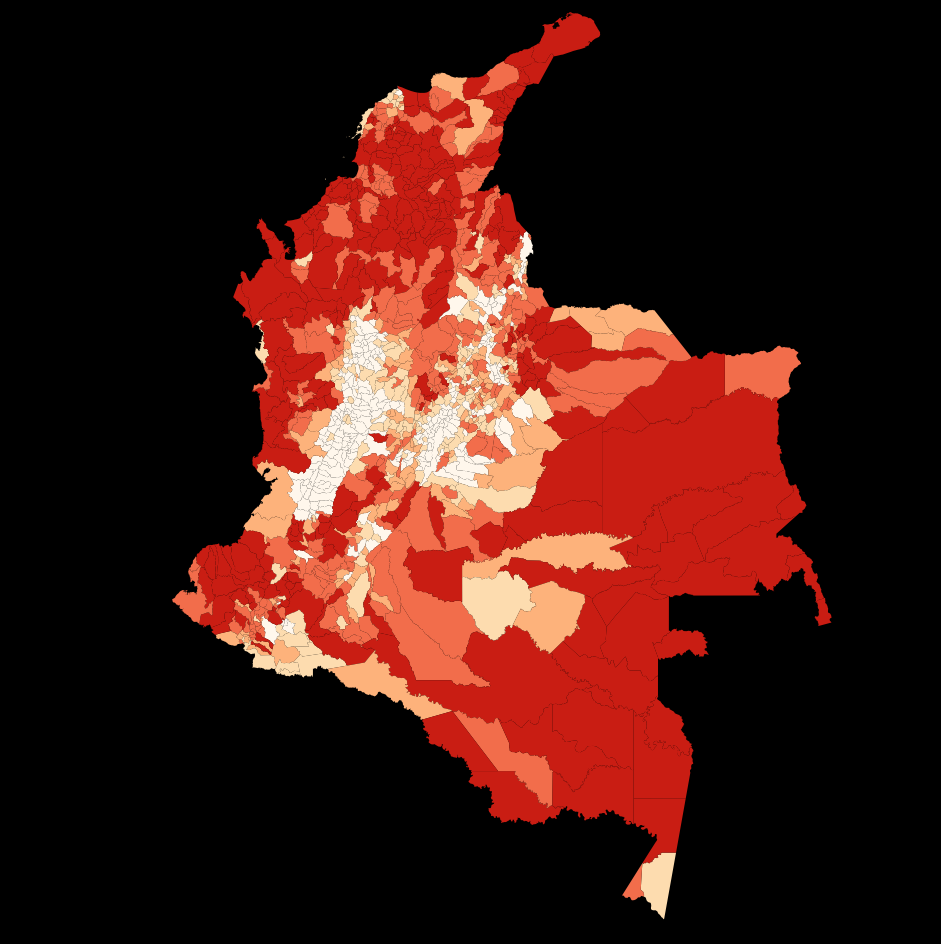

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

nbi_2005['bin_data2'] = pd.cut(nbi_2005['miseria'], bins=bins3, labels=[f'{bins3[i]}-{bins3[i+1]}' for i in range(len(bins3)-1)], include_lowest=True)
nbi_2005.plot(column='bin_data2', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=nbi_2005.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('nbi_mise_2005.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('nbi_mise_2005.png')

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


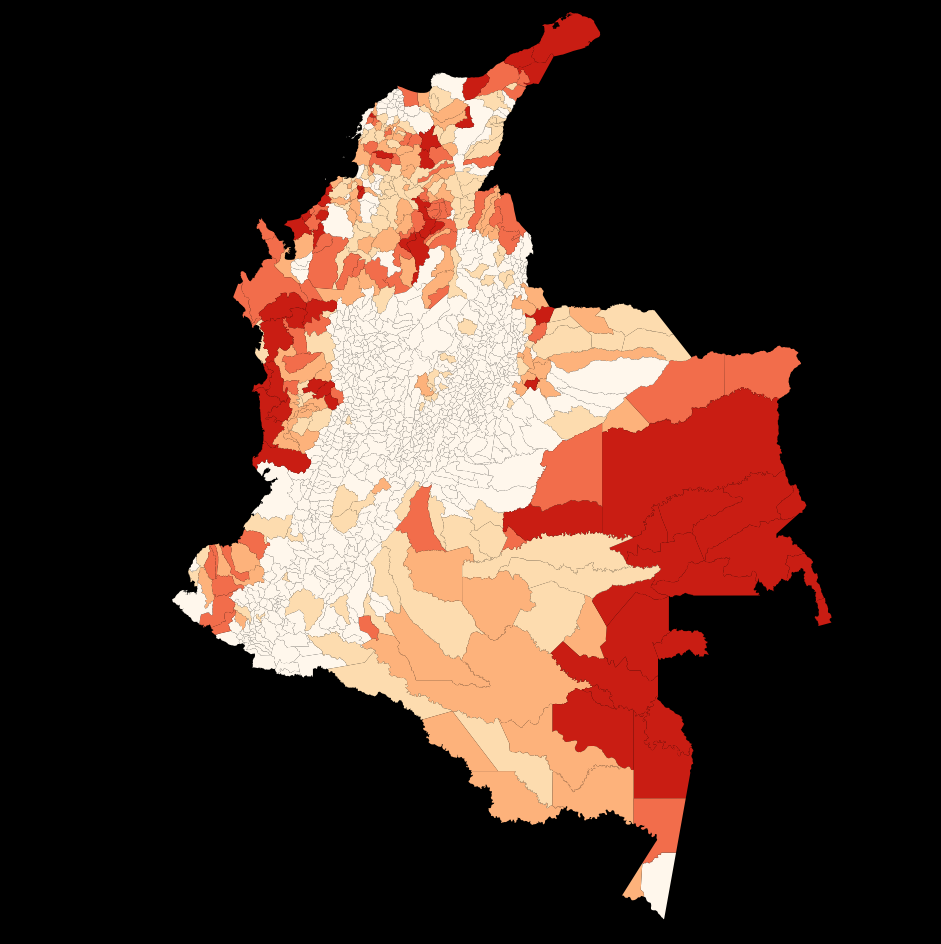

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

nbi_2018['bin_data2'] = pd.cut(nbi_2018['miseria'], bins=bins3, labels=[f'{bins3[i]}-{bins3[i+1]}' for i in range(len(bins3)-1)], include_lowest=True)
nbi_2018.plot(column='bin_data2', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=nbi_2018.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)

ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('nbi_mise_2018.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('nbi_mise_2018.png')

#### raster

In [ ]:
bins3 = [0, 6.65, 10.48, 15, 26.85, 100, float('inf')]

# Filtrar por año
nbi_2005 = nbi[nbi['anio'] == 2005].copy()
nbi_2018 = nbi[nbi['anio'] == 2018].copy()

# Generar imágenes de clases
generar_raster_nbi(nbi_2005, columna_valor='miseria', bins=bins3, output_path='nbi_mise_2005_labels.png')
generar_raster_nbi(nbi_2018, columna_valor='miseria', bins=bins3, output_path='nbi_mise_2018_labels.png')

 Imagen guardada: nbi_mise_2005_labels.png
 Imagen guardada: nbi_mise_2018_labels.png


.tif

In [ ]:
bins3 = [0, 6.65, 10.48, 15, 26.85, 100, float('inf')]

# Filtrar por año
nbi_2005 = nbi[nbi['anio'] == 2005].copy()
nbi_2018 = nbi[nbi['anio'] == 2018].copy()

# Generar imágenes de clases
generar_raster_nbi_tif(nbi_2005, columna_valor='miseria', bins=bins3, output_path='/content/drive/MyDrive/Imagen_unet/nbi_mise_2005_labels.tif')
generar_raster_nbi_tif(nbi_2018, columna_valor='miseria', bins=bins3, output_path='/content/drive/MyDrive/Imagen_unet/nbi_mise_2018_labels.tif')

 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/nbi_mise_2005_labels.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/nbi_mise_2018_labels.tif


## Deficit cualitativo de vivienda

### Agua para cocinar

In [ ]:
cuartiles_agua_cocinar = vivienda['agua_para_cocinar'].quantile([0, 0.25, 0.5, 0.75, 1])
cuartiles_agua_cocinar

0.00        1.0
0.25      329.0
0.50      699.0
0.75     1425.5
1.00    26733.0
Name: agua_para_cocinar, dtype: float64

In [ ]:
bins4 = [0, 330, 700, 1427, 26733,  float('inf')]

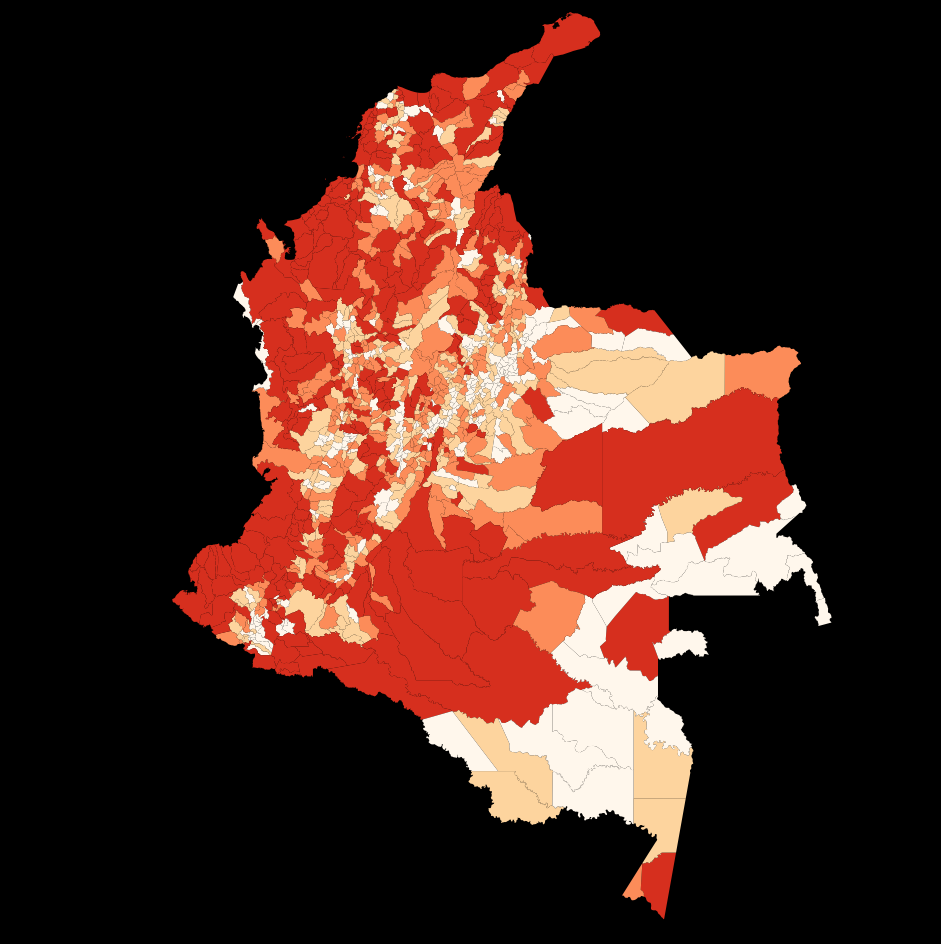

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

vivienda['bin_data'] = pd.cut(vivienda['agua_para_cocinar'], bins=bins4, labels=[f'{bins4[i]}-{bins4[i+1]}' for i in range(len(bins4)-1)], include_lowest=True)
vivienda.plot(column='bin_data', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=vivienda.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)
ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')

plt.savefig('def_agua.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('def_agua.png')

### Alcantarillado

In [ ]:
cuartiles_alcantarillado = vivienda['alcantarillado'].quantile([0, 0.25, 0.5, 0.75, 1])
cuartiles_alcantarillado

0.00       19.00
0.25      230.75
0.50      636.00
0.75     1568.00
1.00    56063.00
Name: alcantarillado, dtype: float64

In [ ]:
bins5 = [19, 232, 637, 1570, 56063, float('inf')]


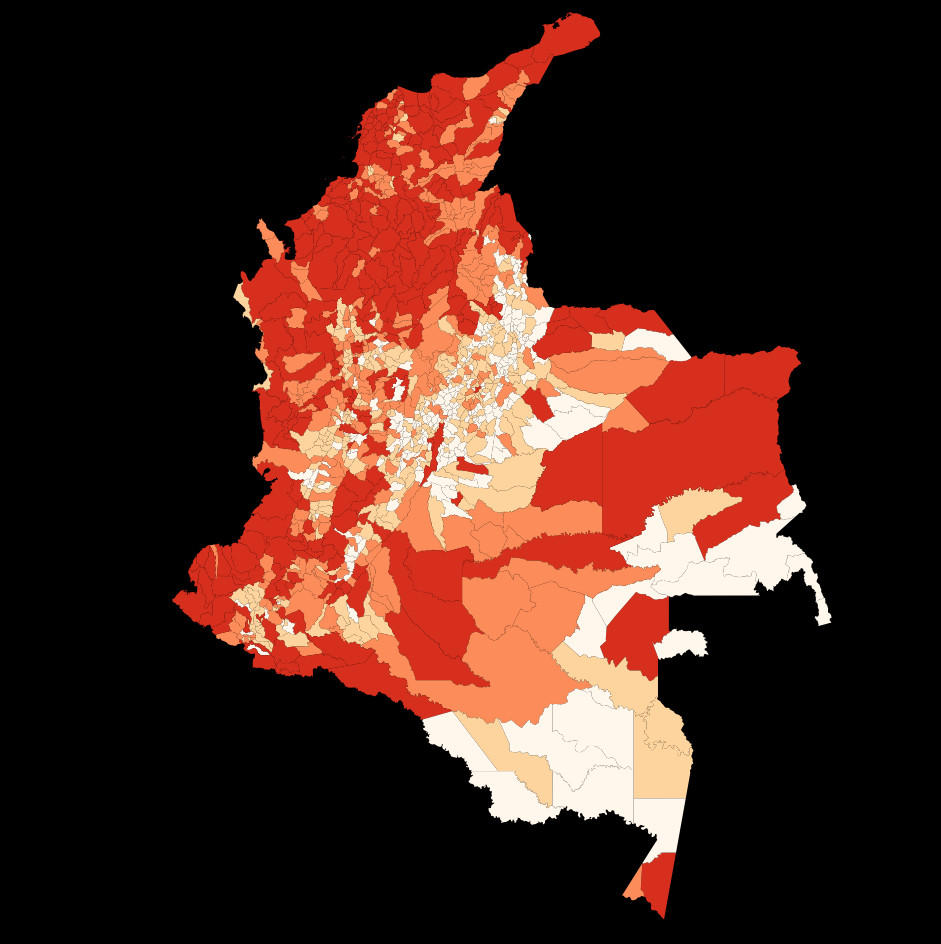

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

vivienda['bin_data2'] = pd.cut(vivienda['alcantarillado'], bins=bins5, labels=[f'{bins5[i]}-{bins5[i+1]}' for i in range(len(bins5)-1)], include_lowest=True)
vivienda.plot(column='bin_data2', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=vivienda.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)
ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')
plt.savefig('def_alc.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('def_alc.png')

### Recolección de basura

In [ ]:
cuartiles_recoleccion_de_basuras= vivienda['recoleccion_de_basuras'].quantile([0, 0.25, 0.5, 0.75, 1])
cuartiles_recoleccion_de_basuras

0.00        0.0
0.25       90.0
0.50      390.0
0.75     1254.0
1.00    30981.0
Name: recoleccion_de_basuras, dtype: float64

In [ ]:
print(min(vivienda['recoleccion_de_basuras']))
print(max(vivienda['recoleccion_de_basuras']))

0
30981


In [ ]:
bins6 = [0, 91, 390, 1254, 30982, float('inf')]


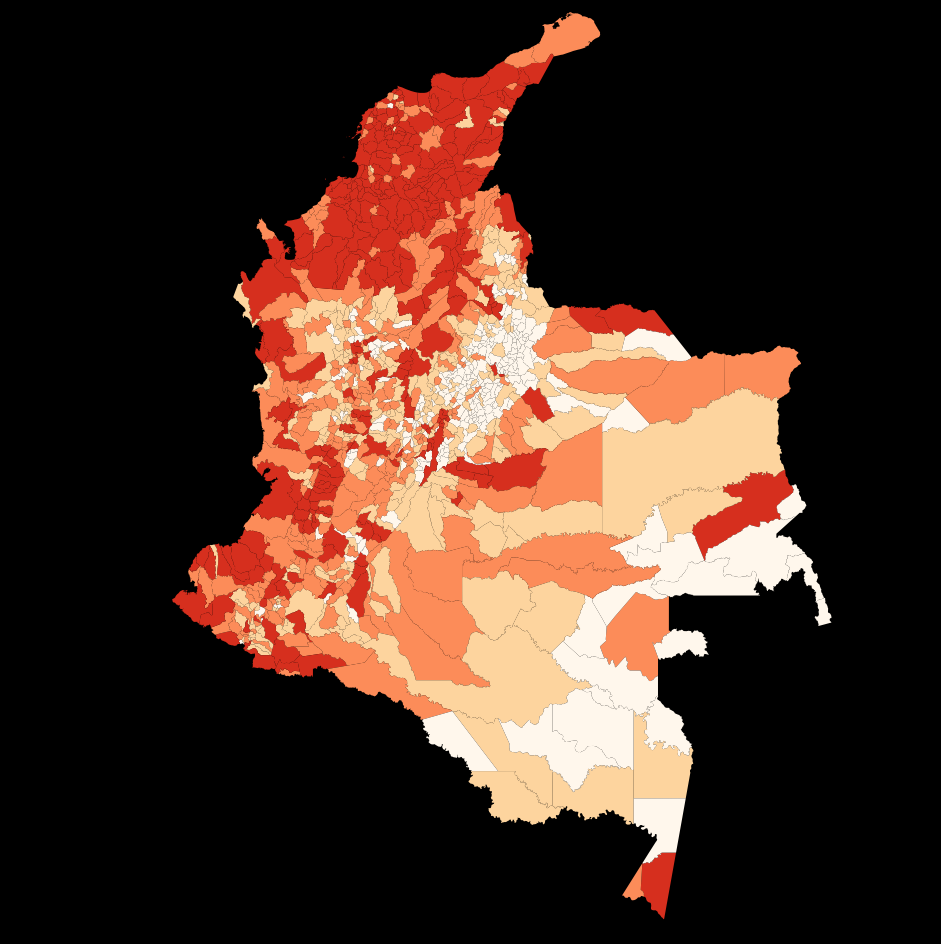

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), facecolor='black')

vivienda['bin_data3'] = pd.cut(vivienda['recoleccion_de_basuras'], bins=bins6, labels=[f'{bins6[i]}-{bins6[i+1]}' for i in range(len(bins6)-1)], include_lowest=True)
vivienda.plot(column='bin_data3', cmap='OrRd', linewidth=0, ax=ax, edgecolor='0.4', legend=False)
ctx.add_basemap(ax, crs=vivienda.crs.to_string(), attribution=False, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0)
ax.set_xlim([-82, -65])
ax.set_ylim([-4.5, 12.5])

ax.axis('off')
plt.savefig('def_bas.png', facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
from google.colab import files
files.download('def_bas.png')

## Después

In [3]:
!pip install rasterio
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 91.0 MB/s eta 0:00:00


### Género

In [ ]:
cuartiles_hombres = edad_sexo['Total Hombres'].quantile([0, 0.25, 0.5, 0.75, 1])
cuartiles_hombres
cuartiles_mujeres = edad_sexo['Total Mujeres'].quantile([0, 0.25, 0.5, 0.75, 1])
cuartiles_mujeres

Cuartiles de Total Hombres:
0.00          0.00
0.25       3294.00
0.50       6305.00
0.75      12819.25
1.00    3633389.00
Name: Total Hombres, dtype: float64
Cuartiles de Total Mujeres:


0.00          0.00
0.25       3120.00
0.50       6017.50
0.75      12411.75
1.00    3959482.00
Name: Total Mujeres, dtype: float64

In [ ]:
promedio_cuartiles = (cuartiles_hombres + cuartiles_mujeres) / 2
promedio_cuartiles

0.00          0.00
0.25       3207.00
0.50       6161.25
0.75      12615.50
1.00    3796435.50
dtype: float64

In [35]:
def generar_raster_nbi_tif(gdf, columna_valor, bins, output_path, out_shape=(1024, 1024)):
    # Crear clases
    clases = list(range(len(bins) - 1))
    gdf['clase'] = pd.cut(
        gdf[columna_valor],
        bins=bins,
        labels=clases,
        include_lowest=True
    ).astype(np.uint8)

    # Transformación espacial
    transform = from_bounds(-82, -4.5, -65, 12.5, *out_shape)

    # Rasterizar
    shapes = [
        (geom, int(value))
        for geom, value in zip(gdf.geometry, gdf['clase'])
        if not pd.isna(value)
    ]
    raster = rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=255,
        dtype=np.uint8
    )

    # Guardar como TIFF
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",
        transform=transform
    ) as dst:
        dst.write(raster, 1)

    print(f" GeoTIFF guardado: {output_path}")

In [ ]:
bins = [0, 3207, 6161, 12616, float('inf')]

for año in range(2007, 2020):
    edad_sexo_año = edad_sexo[edad_sexo['AÑO'] == año].copy()
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total Hombres', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Sexo_hombres/{año}.tif')
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total Mujeres', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Sexo_mujeres/{año}.tif')

 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2009.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2009.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2010.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2010.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2011.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2011.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2012.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2012.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Sexo_hombres/2013.tif
 GeoTIFF gua

### Edad

In [30]:
edad_sexo['Total_menos5'] = edad_sexo[[f'Total_{i}' for i in range(0, 5)]].sum(axis=1)
edad_sexo['Total_5_14'] = edad_sexo[[f'Total_{i}' for i in range(5, 15)]].sum(axis=1)
edad_sexo['Total_15_49'] = edad_sexo[[f'Total_{i}' for i in range(15, 50)]].sum(axis=1)
edad_sexo['Total_50_69'] = edad_sexo[[f'Total_{i}' for i in range(50, 70)]].sum(axis=1)
edad_sexo['Total_70mas'] = edad_sexo[[f'Total_{i}' for i in range(70, 85)]].sum(axis=1) + edad_sexo['Total_85 y más']

In [31]:
edad_sexo.iloc[:, -5:].quantile([0, 0.25, 0.5, 0.75, 1])

Total_menos5  Total_5_14  Total_15_49  Total_50_69  Total_70mas
0.00           0.0        0.00          0.0         0.00          0.0
0.25         549.0     1183.00       3098.0      1051.25        396.0
0.50        1149.5     2392.00       6054.5      1920.00        696.0
0.75        2437.0     5049.25      12661.0      3802.00       1301.0
1.00      568466.0  1300352.00    4245863.0   1471216.00     418991.0

In [32]:
# Cuartiles globales
pd.Series(edad_sexo.iloc[:, -5:].values.flatten()).quantile([0, 0.25, 0.5, 0.75, 1])

0.00          0.0
0.25        796.0
0.50       1832.0
0.75       4562.0
1.00    4245863.0
dtype: float64

In [33]:
edad_sexo.head(1)

MPIO_CNMBR          AREA   LATITUD   LONGITUD  DPTO_Code  MPIO_ccdgo  \
0  FLORENCIA  2.547638e+09  1.749139 -75.558239         18           1   

   MPIO_Code                                           geometry  DP    DPNOM  \
0      18001  POLYGON ((-75.42074 2.19413, -75.42042 2.19412...  18  Caquetá   

   ... Total_84  Total_85 y más  Total Hombres Total Mujeres  Total General  \
0  ...      130             744          79664         78503         158167   

   Total_menos5  Total_5_14  Total_15_49  Total_50_69  Total_70mas  
0         16894       33503        85062        17426         5282  

[1 rows x 280 columns]

In [37]:
bins = [0, 796, 1832, 4562, float('inf')]
edad_sexo_año = edad_sexo[edad_sexo['AÑO'] == 2007].copy()
generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_menos5', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/{2007}.tif')

 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/2007.tif


In [ ]:
#Generación de imagenes
bins = [0, 796, 1832, 4562, float('inf')]

for año in range(2007, 2020):
    edad_sexo_año = edad_sexo[edad_sexo['AÑO'] == año].copy()
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_menos5', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Edad_menos5/{año}.tif')
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_5_14', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Edad_5_14/{año}.tif')
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_15_49', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Edad_15_49/{año}.tif')
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_50_69', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Edad_50_69/{año}.tif')
    generar_raster_nbi_tif(edad_sexo_año, columna_valor='Total_70mas', bins=bins, output_path=f'/content/drive/MyDrive/Imagen_unet/Edad_70mas/{año}.tif')

 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_menos5/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_5_14/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_15_49/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_50_69/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_70mas/2007.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_menos5/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_5_14/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_15_49/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_50_69/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_70mas/2008.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_menos5/2009.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_5_14/2009.tif
 GeoTIFF guardado: /content/drive/MyDrive/Imagen_unet/Edad_15_49/2009.tif
 GeoTIFF guardado: /content/drive/MyDr

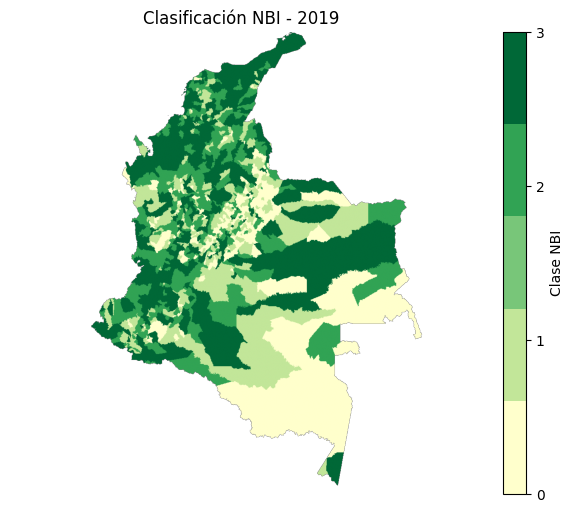

In [ ]:
#ruta_tif = "/content/drive/MyDrive/Imagen_unet/Edad_70mas/2019.tif"
ruta_tif = "/content/drive/MyDrive/Imagen_unet/Sexo_mujeres/2013.tif"

# Abrir el raster
with rasterio.open(ruta_tif) as src:
    raster = src.read(1)
raster = raster.astype(float)
raster[raster == 255] = np.nan

# Graficar
colores = ['#ffffcc', '#c2e699', '#78c679', '#31a354', '#006837']
cmap = ListedColormap(colores)
plt.figure(figsize=(8, 6))
img = plt.imshow(raster, cmap=cmap)
plt.colorbar(img, ticks=range(len(colores)))
plt.axis('off')
plt.show()